# Daily Activity Analysis with Fitbit Tracker Data

## Initial Setup

Import libraries needed and do configuration for the notebook

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import wilcoxon
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

warnings.simplefilter("ignore", (UserWarning, FutureWarning))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Params for plotting
plt.rcParams.update({'font.size': 20})
sns.set(style="whitegrid", font_scale=1.5)

# Constants
SEED = 99

setup path to the data

In [98]:
# Path to the directory containing the data

# This is the path to the data on my home PC
base_path = r"D:\OneDrive - Aalto University\5.vuosi\dhhb\project\data\mturkfitbit_export_4.12.16-5.12.16\Fitabase Data 4.12.16-5.12.16" + "\\"

# This is the path to the data on my laptop
# base_path = r"C:\Users\ilkka\OneDrive - Aalto University\5.vuosi\dhhb\project\data\mturkfitbit_export_4.12.16-5.12.16\Fitabase Data 4.12.16-5.12.16" + "\\"

### Load the data and take a quick overview

In [99]:
# In the dailyActivity_merged.csv file we can find the overview information of the daily activities of the users

print(base_path)

df_activity = pd.read_csv(base_path + "dailyActivity_merged.csv")
# Let us output some information about the dataframe
df_activity.head()
df_activity.info()
df_activity.describe()
df_activity.shape
df_activity['Id'].nunique()

D:\OneDrive - Aalto University\5.vuosi\dhhb\project\data\mturkfitbit_export_4.12.16-5.12.16\Fitabase Data 4.12.16-5.12.16\


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
count,9.400000e+02,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,4.855407e+09,7637.910638,5.489702,5.475351,0.108171,1.502681,0.567543,3.340819,0.001606,21.164894,13.564894,192.812766,991.210638,2303.609574
std,2.424805e+09,5087.150742,3.924606,3.907276,0.619897,2.658941,0.883580,2.040655,0.007346,32.844803,19.987404,109.174700,301.267437,718.166862
min,1.503960e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.320127e+09,3789.750000,2.620000,2.620000,0.000000,0.000000,0.000000,1.945000,0.000000,0.000000,0.000000,127.000000,729.750000,1828.500000
50%,4.445115e+09,7405.500000,5.245000,5.245000,0.000000,0.210000,0.240000,3.365000,0.000000,4.000000,6.000000,199.000000,1057.500000,2134.000000
75%,6.962181e+09,10727.000000,7.712500,7.710000,0.000000,2.052500,0.800000,4.782500,0.000000,32.000000,19.000000,264.000000,1229.500000,2793.250000
max,8.877689e+09,36019.000000,28.030001,28.030001,4.942142,21.920000,6.480000,10.710000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000


(940, 15)

33

Luckily, the data does not have any missing values. There are 33 subjects attended in the dataset. The data frame contains 940 rows and 15 columns.


Let's check same properties of other tow datasets, one containing sleep statistics and one containing weight statistics.

In [100]:

df_weight = pd.read_csv(base_path + "weightLogInfo_merged.csv")
# Let us output some information about the dataframe
df_weight.head()
df_weight.info()
df_weight.describe()
df_weight.shape
df_weight['Id'].nunique()

,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000
3,2873212765,4/21/2016 11:59:59 PM,56.700001,125.002104,NaN,21.450001,True,1461283199000
4,2873212765,5/12/2016 11:59:59 PM,57.299999,126.324875,NaN,21.690001,True,1463097599000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              67 non-null     int64  
 1   Date            67 non-null     object 
 2   WeightKg        67 non-null     float64
 3   WeightPounds    67 non-null     float64
 4   Fat             2 non-null      float64
 5   BMI             67 non-null     float64
 6   IsManualReport  67 non-null     bool   
 7   LogId           67 non-null     int64  
dtypes: bool(1), float64(4), int64(2), object(1)
memory usage: 3.9+ KB


,Id,WeightKg,WeightPounds,Fat,BMI,LogId
count,6.700000e+01,67.000000,67.000000,2.00000,67.000000,6.700000e+01
mean,7.009282e+09,72.035821,158.811801,23.50000,25.185224,1.461772e+12
std,1.950322e+09,13.923206,30.695415,2.12132,3.066963,7.829948e+08
min,1.503960e+09,52.599998,115.963147,22.00000,21.450001,1.460444e+12
25%,6.962181e+09,61.400002,135.363832,22.75000,23.959999,1.461079e+12
50%,6.962181e+09,62.500000,137.788914,23.50000,24.389999,1.461802e+12
75%,8.877689e+09,85.049999,187.503152,24.25000,25.559999,1.462375e+12
max,8.877689e+09,133.500000,294.317120,25.00000,47.540001,1.463098e+12


(67, 8)

8

The weight dataset contains 67 rows and 5 columns. There are 8 unique subjects in the dataset.


In [101]:
df_sleep = pd.read_csv(base_path + "sleepDay_merged.csv")
# Let us output some information about the dataframe
df_sleep.head()
df_sleep.info()
df_sleep.describe()
df_sleep.shape
df_sleep['Id'].nunique()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  413 non-null    int64 
 1   SleepDay            413 non-null    object
 2   TotalSleepRecords   413 non-null    int64 
 3   TotalMinutesAsleep  413 non-null    int64 
 4   TotalTimeInBed      413 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.3+ KB


,Id,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
count,4.130000e+02,413.000000,413.000000,413.000000
mean,5.000979e+09,1.118644,419.467312,458.639225
std,2.060360e+09,0.345521,118.344679,127.101607
min,1.503960e+09,1.000000,58.000000,61.000000
25%,3.977334e+09,1.000000,361.000000,403.000000
50%,4.702922e+09,1.000000,433.000000,463.000000
75%,6.962181e+09,1.000000,490.000000,526.000000
max,8.792010e+09,3.000000,796.000000,961.000000


(413, 5)

24

The sleep dataset contains 413 rows and 5 columns. There are 24 unique subjects in the dataset.


The feature 'TotalSleepRecords' doesn't seem to be informative for this analysis and thus we drop it here:

In [102]:
df_sleep = df_sleep.drop('TotalSleepRecords', axis=1)

<br><br>Since we're first considering exploring the the relationship between the daily activity and the sleep, it is interesting to check how many common subjects there are between the two datasets. Let's check that here:


In [103]:
# Common IDs
common_ids = set(df_activity['Id']).intersection(set(df_sleep['Id']))
num_common_ids = len(common_ids)

# Unique IDs (in either series but not both)
unique_ids = set(df_activity['Id']).symmetric_difference(set(df_sleep['Id']))
num_unique_ids = len(unique_ids)

print(f"Number of common IDs: {num_common_ids}")
print(f"Number of unique IDs: {num_unique_ids}")
print(f"Unique ids in df: {df_activity['Id'].nunique()}")
print(f"Unique ids in df_sleep: {df_sleep['Id'].nunique()}")

Number of common IDs: 24
Number of unique IDs: 9
Unique ids in df: 33
Unique ids in df_sleep: 24


It seems that there are 24 common subjects between the two datasets. And all of them are present in sleep dataset. 6 of them are only present in daily activity dataset.


## Exploring the relationship between daily activity and sleep


##### Merging the datasets and other preprocessing


Let us start by merging the df_sleep and df_activity into one pandas DataFrame using keys Id and Date.<br>
To merge the two datasets, we need to make sure that the Id and Date columns are the same in both datasets, especially that the columns containing the date are in the correct format. We will start by naming the "ActivityDate" column in df_activity as "Date" and the "SleepDate" column in df_sleep as "Date". Then we will convert the Date columns to datetime format in both datasets:


In [104]:
df_activity = df_activity.rename(columns={"ActivityDate": "Date"})
df_sleep = df_sleep.rename(columns={"SleepDay": "Date"})

# Convert the Date columns to datetime format
df_activity['Date'] = pd.to_datetime(df_activity['Date'])
df_sleep['Date'] = pd.to_datetime(df_sleep['Date'])

type(df_activity['Date'].dtype), type(df_sleep['Date'].dtype)


(numpy.dtypes.DateTime64DType, numpy.dtypes.DateTime64DType)

As we saw earlier when we print out the few first columns of the sleep dataset, the Date column is in the format of "4/12/2016 12:00:00 AM". This means that this sleep record is from the night between 11th and 12th day of the month. If we were to now merge the two datasets, we would end up with a dataframe containing an activity record for each day with a sleep record from the night before at the same row.<br>
However, it would seem more interesting to have a dataframe where each row contains an activity record and a sleep record from the following night.<br>
To achieve this, we will have to shift the sleep records' dates by one day backward. Let us do that:



In [105]:
# shift the sleep records' dates by one day backward
df_sleep['Date'] = df_sleep['Date'] - pd.Timedelta(days=1)

# Take a look at the first few rows of the sleep dataset to check that the dates have been shifted correctly and take a look at the activity dataset as well
df_sleep['Date'].head()
df_activity['Date'].head()


0   2016-04-11
1   2016-04-12
2   2016-04-14
3   2016-04-15
4   2016-04-16
Name: Date, dtype: datetime64[ns]

0   2016-04-12
1   2016-04-13
2   2016-04-14
3   2016-04-15
4   2016-04-16
Name: Date, dtype: datetime64[ns]

It seems that the dates have been shifted correctly. Now we can merge the two datasets on the Id and Date columns:


In [106]:
df = df_activity.merge(df_sleep, on=("Id", "Date")).drop_duplicates()
df.head()
print("The merged dataframe contains", df.shape[0], "rows and", df.shape[1], "columns.")


,Id,Date,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,384,407
1,1503960366,2016-04-14,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,412,442
2,1503960366,2016-04-15,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,340,367
3,1503960366,2016-04-16,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,700,712
4,1503960366,2016-04-18,13019,8.59,8.59,0.0,3.25,0.64,4.71,0.0,42,16,233,1149,1921,304,320


The merged dataframe contains 397 rows and 17 columns.


As expected, we lost some of the records from the original datasets, but we still have 397 rows in the merged dataframe.<br>
We see from the output above that the datframe index is the default numerical one. For convenience we should use the [datetime index](https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html) which can be easily obtained from the *Date* column. After setting the date as the index, we can proceed to drop the date column. Let's do that here:

In [107]:
df.index = df.Date
df = df.drop('Date', axis=1)
df.index, df.columns

(DatetimeIndex(['2016-04-12', '2016-04-14', '2016-04-15', '2016-04-16',
                '2016-04-18', '2016-04-19', '2016-04-20', '2016-04-22',
                '2016-04-23', '2016-04-24',
                ...
                '2016-04-21', '2016-04-22', '2016-04-26', '2016-04-27',
                '2016-04-28', '2016-04-29', '2016-04-30', '2016-05-01',
                '2016-05-02', '2016-05-03'],
               dtype='datetime64[ns]', name='Date', length=397, freq=None),
 Index(['Id', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
        'LoggedActivitiesDistance', 'VeryActiveDistance',
        'ModeratelyActiveDistance', 'LightActiveDistance',
        'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
        'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories',
        'TotalMinutesAsleep', 'TotalTimeInBed'],
       dtype='object'))

Let's now continue to visualize the data.

### Exploring the relationship between daily activity and sleep at the **individual level**


#### Preprocessing and explorative visualization at the **individual level**



*Tähän yksilötasolla analyysiä*

##### Visualizing the data

Let's first pick a single subject to our individual level analysis. We'll decide on the subject by taking the one with the most entries

In [108]:
# the most common id
most_common_id = df['Id'].value_counts().index[0]
most_common_id
# rows of the most common patient
df_indiv = df[df['Id'] == most_common_id]
df_indiv.shape

5553957443

(30, 16)

The most common patien is the patient with id 5553957443 and has 30 rows in the dataframe

As we saw at the start of this notebook (using describe method), the features in the dataframe have very varying scales. This can cause some of the features to overdominate unless we scale the features. Let us do the scaling next:

In [109]:
# Note that the scaling is done only to this individual subject here, and we should perform the scaling again to the dataframe containing all of the data

sc = StandardScaler()
df_indiv_scaled = df_indiv.copy()
# df_indiv_scaled = df_indiv_scaled.astype({'TotalTimeInBed': 'float64'})
df_indiv_scaled.iloc[:, 1:] = df_indiv_scaled.iloc[:, 1:].astype(np.float64)
# Exclude the Id column from the scaling
df_indiv_scaled.iloc[:, 1:] = sc.fit_transform(df_indiv_scaled.iloc[:, 1:])
df_indiv_scaled.head()

,Id,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed
Date,,,,,,,,,,,,,,,,
2016-04-12,5553957443,0.563329,0.555395,0.555395,0.0,-0.080253,0.153377,1.276948,0.0,-0.203540,-0.016594,1.082339,0.704086,0.413743,-0.085329,-0.168085
2016-04-13,5553957443,-0.797335,-0.797556,-0.797556,0.0,-0.969305,-0.928480,-0.298234,0.0,-0.987446,-0.941136,0.240030,-0.304553,-0.718994,-0.990990,-0.778776
2016-04-14,5553957443,1.654838,1.644505,1.644505,0.0,1.626469,2.426648,0.758888,0.0,1.529303,1.974727,0.735506,0.082092,1.509704,-0.806161,-0.857294
2016-04-15,5553957443,1.561096,1.564739,1.564739,0.0,1.730300,1.783011,0.786891,0.0,1.405529,1.761371,0.454736,0.048471,1.252263,1.725991,1.559297
2016-04-16,5553957443,-0.608443,-0.610413,-0.610413,0.0,-0.969305,-0.928480,0.128815,0.0,-0.987446,-0.941136,1.264013,-1.363624,-0.303412,-1.055680,-0.918363


**Boxplot** of the features of the subject

We follow the same procedure as in the programming assignment 2 as1 of the course [[1]](#references):<br>
"<br>
Before we plot the dataframe using `seaborn`, we need to convert the dataframe from wide to long format. We use the [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function for Dataframe where one or more columns are identifier variables (`id_vars`), with the remaining columns being measured variables (`value_vars`). For more information about wide and long data formats, refer to [this wikipedia article](https://en.wikipedia.org/wiki/Wide_and_narrow_data).<br>
"

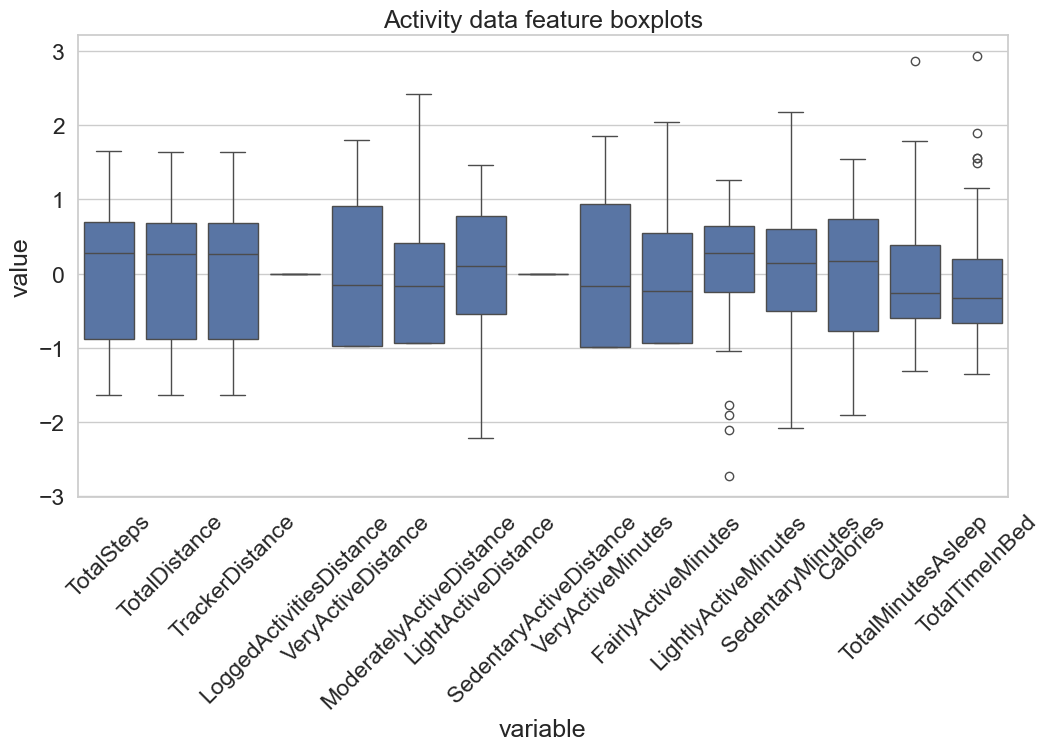

In [110]:
df_copy_melt = pd.melt(df_indiv_scaled.iloc[:, 1:])

# Next, we'll create a feature-wise boxplot
res = plt.figure(figsize=(12, 6)) # capture results to supress redundant outputs

res = ax = sns.boxplot(x="variable",
                      y="value", 
                      data=df_copy_melt)
res = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
res = ax.set(title='Activity data feature boxplots')

plt.show()

It seems that the features *LightlyActiveMinutes* and *TotalTimeInBed* have more outlying values than other features. Notice how the the boxplots show the scaled values.

**Boxplots** depicting the distributions of activity and total sleep by weekday:

Let's make couple new columns. One that shows the corresponding weekday of a row and one that contains the sum of active minutes of a row (sum of all activity minutes except sedentary) (which we will also normalize), and then use that information to plot the distributions of total activity minutes and total minutes asleep by weekday. Along the boxplots let's also superimpose individual observations in one figure.

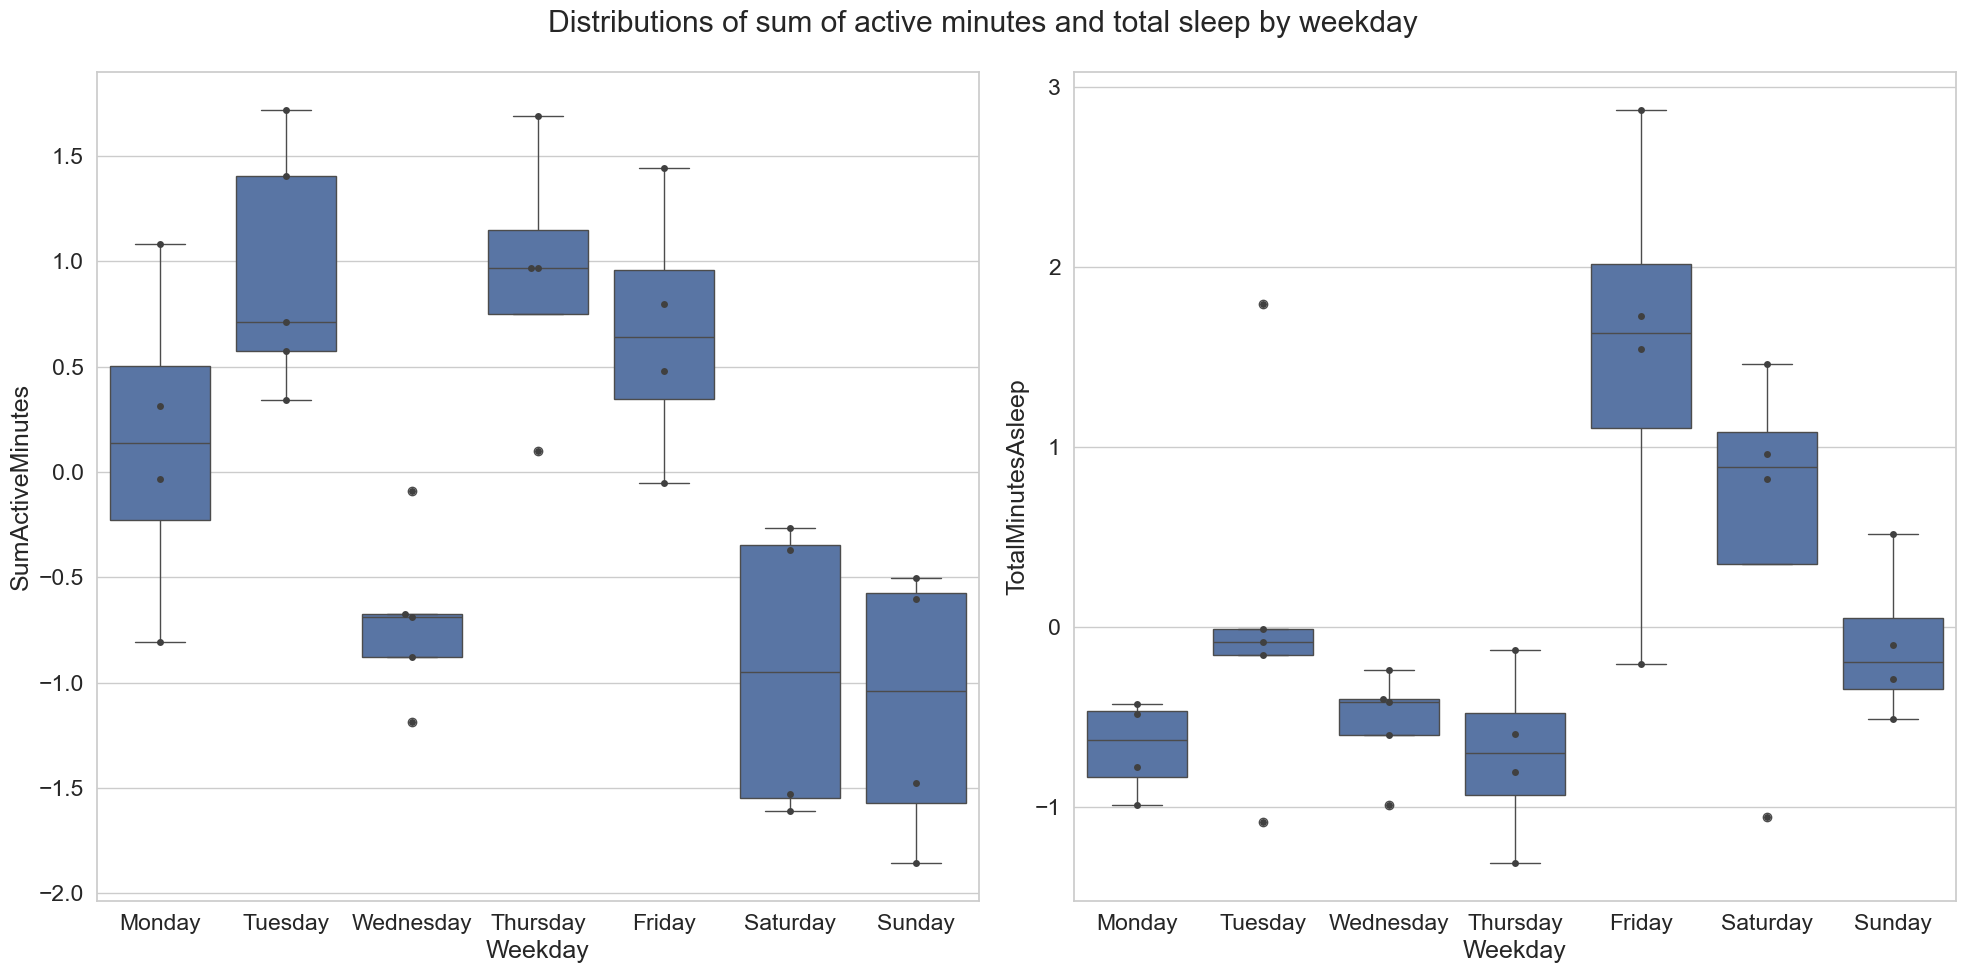

In [111]:
# Create Weekday column
df_indiv_scaled['Weekday'] = df_indiv_scaled.index.day_name()

# Create SumActiveMinutes
active_columns = ["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes"]
df_indiv_scaled['SumActiveMinutes'] = df_indiv_scaled[active_columns].sum(axis=1)

# To keep our visualization focused on normalized values, let's normalize the summation column using standard scaling
sc = StandardScaler()
df_indiv_scaled["SumActiveMinutes"] = sc.fit_transform(df_indiv_scaled[["SumActiveMinutes"]])

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
res=fig.suptitle('Distributions of sum of active minutes and total sleep by weekday')

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

res=sns.boxplot(y="SumActiveMinutes",
            x="Weekday",
            order=order,
            data=df_indiv_scaled,
            ax=axes[0])

res=sns.swarmplot(y="SumActiveMinutes", 
              x="Weekday",
              order=order,
              data=df_indiv_scaled, 
              color=".25",
              ax=axes[0])

res=sns.boxplot(y="TotalMinutesAsleep",
            x="Weekday",
            order=order,
            data=df_indiv_scaled,
            ax=axes[1])

res=sns.swarmplot(y="TotalMinutesAsleep", 
              x="Weekday",
              order=order,
              data=df_indiv_scaled, 
              color=".25",
              ax=axes[1])

fig.tight_layout()
plt.show()

It seems that the subject is significantly less active on weekend, and on Wednesday, but then tends to sleep a lot more on weekends (including Friday) than on weekdays.

**Visualizing daily activity together with total sleep**<br><br>
Lastly, let's focus on the daily activity and total sleep of this individual subject.<br>
We'll do this by creating a boxplot of the total time aslpee using TotalMinutesAsleep column and the by creating an activity lineplot using the SumActiveMinutes column. We will assign these two plots to the same x axis (that is, superimpose the two plots with shared x axis but with separate y axises). The code below is adapted from the programming assignment 2 from notebook *as1* [[1]](#references).

**Note that we use the _unscaled_ data here!**

C:\Users\Ilkka\AppData\Local\Temp\ipykernel_22836\4146295295.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indiv['Weekday'] = df_indiv.index.day_name()
C:\Users\Ilkka\AppData\Local\Temp\ipykernel_22836\4146295295.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indiv['SumActiveMinutes'] = df_indiv[active_columns].sum(axis=1)


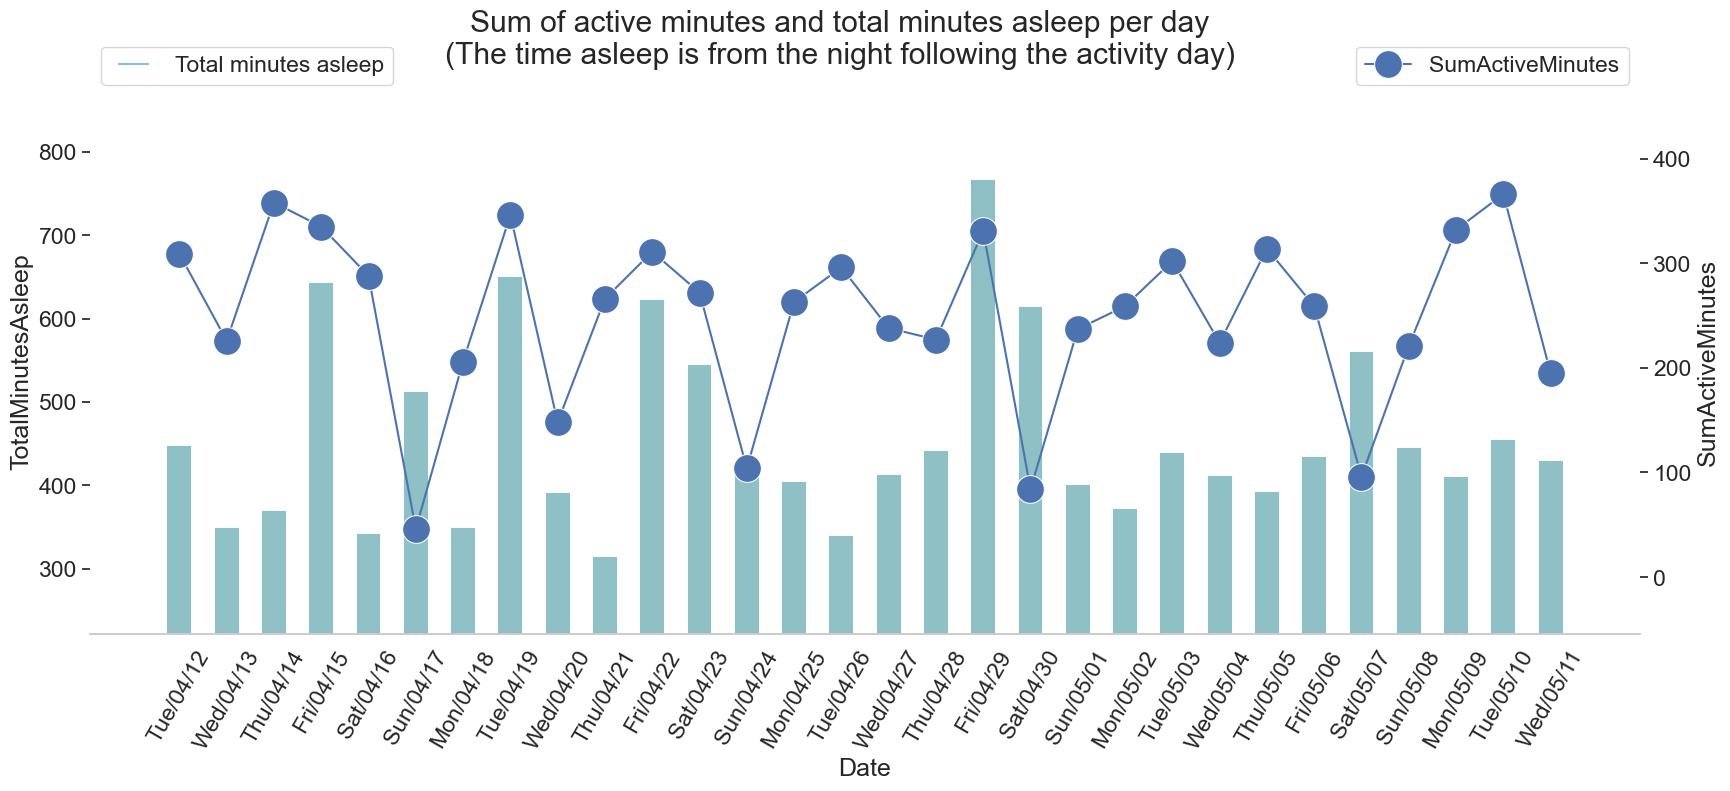

In [112]:
# set intensity of each bar according to values
def bar_color(bar, N: int):
  """
  Args:
    bar: sns.barplot object
    N:   Number of bars in the barplot object
  """
  palette = sns.cubehelix_palette(N*10, start=0, rot=-0.25, dark=0.2, light=0.7)
  
  height = {}
  
  for patch in bar.patches:
    # get each bar's value
    height[patch] = patch.get_height()
  
  # sort by value
  sorted_height = dict(sorted(height.items(), key=lambda item: item[1]))

  count = 0
  for i in sorted_height.keys():
    # apply darkness
    idx = count
    if count/len(sorted_height) > 0.5:
      idx = idx + 10  # Apply more contrast between smaller and larger values
    i.set_facecolor(palette[idx])
    count += 1


# Since we're using the unscaled data, the following columns have to be created:
# Create Weekday column
df_indiv['Weekday'] = df_indiv.index.day_name()

# Create SumActiveMinutes
active_columns = ["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes"]
df_indiv['SumActiveMinutes'] = df_indiv[active_columns].sum(axis=1)

# define the canvas and axes
fig, ax = plt.subplots(figsize=(20, 8), sharex=True)

# barplot of the total minutes asleep
bar = sns.barplot(ax=ax,
                  data=df_indiv,
                  x=df_indiv.index.strftime("%a/%m/%d"),
                  y="TotalMinutesAsleep",
                  label="Total minutes asleep",
                  linewidth=10,)

# set bar color according to their heights
bar_color(bar, df.shape[0])
    
res=ax.set_xlabel("Date")  # set name of x-axis
res=ax.set_ylim(ymax=df_indiv["TotalMinutesAsleep"].max() + 100, ymin=df_indiv["TotalMinutesAsleep"].min() - 100)

# get the twin y-axis
ax_twin = ax.twinx()

# Lineplot of the activity minutes per day
ax2 = sns.lineplot(data=df_indiv,
             label="SumActiveMinutes",
             x=df_indiv.index.strftime("%a/%m/%d"),
             y="SumActiveMinutes",
             ax=ax_twin,
             marker='o',
             markersize=20)

res=ax_twin.set_ylim(ymax=df_indiv["SumActiveMinutes"].max() + 100, ymin=df_indiv["SumActiveMinutes"].min() - 100)

# Set legends locations so that they don't overlap with each other or with the plot
res=ax.legend(loc='upper left', bbox_to_anchor=(0, 1.1))  # Move barplot legend slightly above the plot
res=ax_twin.legend(loc='upper right', bbox_to_anchor=(1, 1.1))  # Move lineplot legend slightly above the plot

res=fig.suptitle("Sum of active minutes and total minutes asleep per day\n(The time asleep is from the night following the activity day)")

# format the figure
res=sns.despine(top=True, right=True, left=True)

# format xticks
res=fig.autofmt_xdate(rotation=60,ha='center')

# Remove grid lines from this specific plot
ax.grid(False)  # Disable grid on the primary y-axis
ax_twin.grid(False)  # Disable grid on the twin y-axis

plt.show()

At some days it seems like more activity leads to more minutes asleep the following night, and we should dig more deep to this finding later!

In addition to the findings above it might be interesting to check the correlation between the features. Let us compute and plot a correlation matrix for the features using pearson correlation as the correlation statistic. Code adapted from [[2]](#references)

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

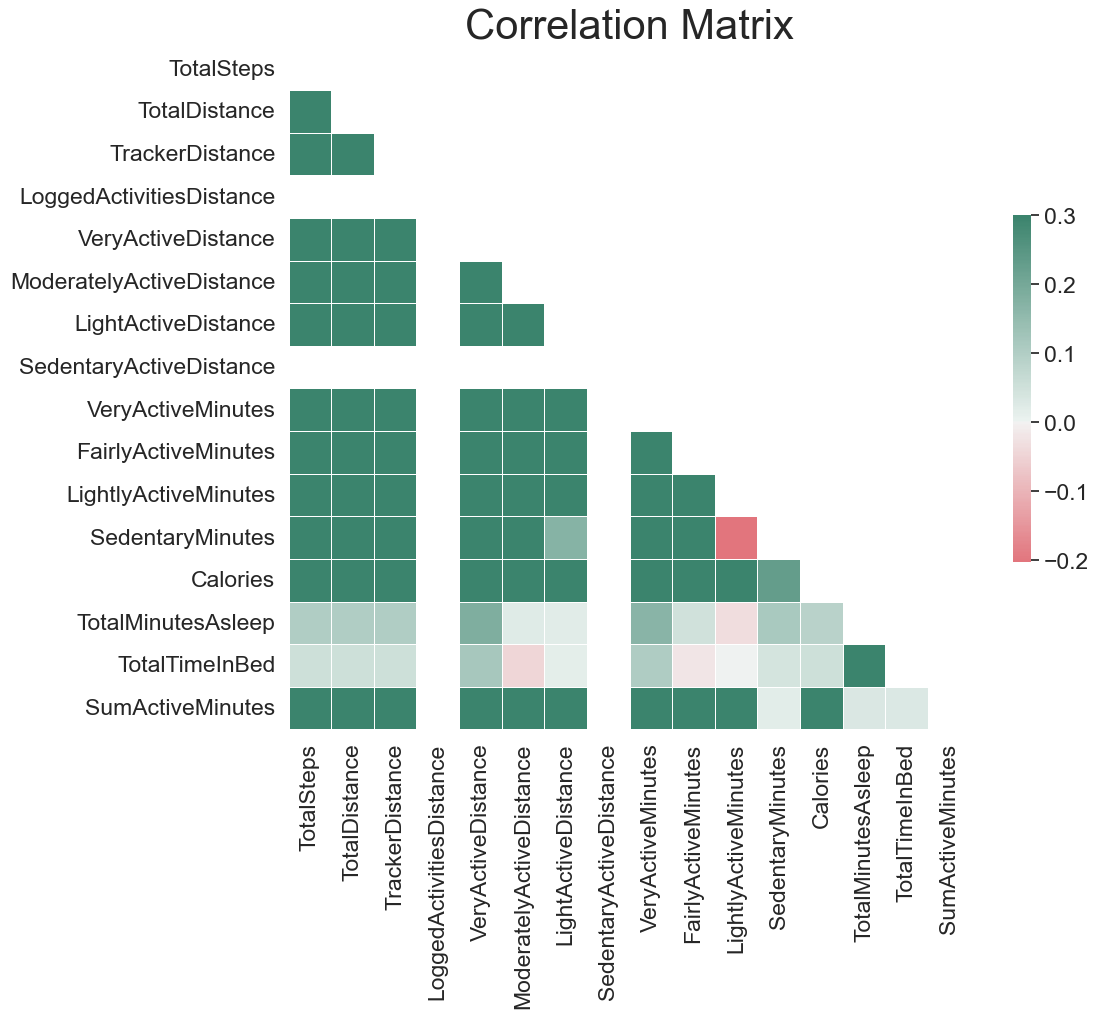

In [113]:
# Drop id and weekday information from the correlation matrix
corr = df_indiv.drop(columns=['Id', 'Weekday']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Don't show the gridlines
ax.grid(False)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(730, 520, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix", fontsize=30)

It seems that there is a positive correlation between very active minutes and total minutes asleep, and same with very active distance and minutes asleep.

Looking at the plot above, it seems that there isn't that strong of a correlation between the sum of active minutes and total minutes asleep (**at the individual level!**). On the other hand there is strong correlation between other features such as between sum of active minutes and calories burned.

...

### Exploring the data at the **group level**, escpecially the relationship between daily activity and sleep at the **group level**


#### Preprocessing and explorative visualization at the **group level**



##### Preprocessing

The analysis at the individual level showed some handy preprocessing steps that we should execute right away before going to the visual exploration of the data. Let's perform the preprosessing here.

Let us start by creating the Weekday and SumActiveMinutes columns

In [114]:
# Create Weekday column
df['Weekday'] = df.index.day_name()

# Create SumActiveMinutes
active_columns = ["VeryActiveMinutes", "FairlyActiveMinutes", "LightlyActiveMinutes"]
df['SumActiveMinutes'] = df[active_columns].sum(axis=1)

# Move the Weekday column next to the Id column for easier later processing
df = df[['Id', 'Weekday'] + list( df.columns.drop(['Weekday', 'Id']) )]
df.head(3)

,Id,Weekday,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed,SumActiveMinutes
Date,,,,,,,,,,,,,,,,,,
2016-04-12,1503960366,Tuesday,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,384,407,366
2016-04-14,1503960366,Thursday,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,412,442,222
2016-04-15,1503960366,Friday,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,340,367,272


Let's then proceed to the scaling phase and create a scaled copy of the original merged data.

In [115]:
sc = StandardScaler()
df_scaled = df.copy(deep=True)

# Exclude the Id and Weekday columns from the scaling
df_scaled.iloc[:, 2:] = df_scaled.iloc[:, 2:].astype(np.float64)
df_scaled.iloc[:, 2:] = sc.fit_transform(df_scaled.iloc[:, 2:])
df_scaled.head()

,Id,Weekday,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed,SumActiveMinutes
Date,,,,,,,,,,,,,,,,,,
2016-04-12,1503960366,Tuesday,1.093411,0.798170,0.801133,-0.219288,0.203167,-0.209575,1.311434,-0.099675,-0.018093,-0.230169,1.292263,-0.224565,-0.586146,-0.290320,-0.397089,1.155648
2016-04-14,1503960366,Thursday,0.442909,0.216417,0.218472,-0.219288,0.492687,-0.355902,0.068568,-0.099675,0.120576,-0.318498,-0.405245,2.115517,-0.874172,-0.054207,-0.123442,-0.413655
2016-04-15,1503960366,Friday,0.274867,0.064368,0.066186,-0.219288,0.337587,0.483038,-0.555755,-0.099675,0.092842,0.697293,-0.081910,-0.234116,-0.916894,-0.661355,-0.709830,0.131242
2016-04-16,1503960366,Saturday,0.974722,0.685786,0.688573,-0.219288,0.632277,-0.346147,0.721795,-0.099675,0.286978,-0.362663,0.056662,-0.009660,-0.754276,2.374386,1.987554,0.076752
2016-04-18,1503960366,Monday,1.058984,0.827918,0.830928,-0.219288,0.911456,-0.121779,0.531030,-0.099675,0.453381,-0.097674,0.195234,1.785995,-0.674346,-0.964929,-1.077299,0.338303


##### Visualizing the data


**Active minutes distribution**<br>
Let's focus on how well people engage in reporting their data by looking at the types of activity.<br>
There are four types of active minutes in the dataset:

- VeryActiveMinutes
- FairlyActiveMinutes
- VeryLightlyActiveMinutes
- SedentaryActiveMinutes (this is originally called SedentaryMinutes, but we'll quickly rename it here while plotting and use that name from now on)


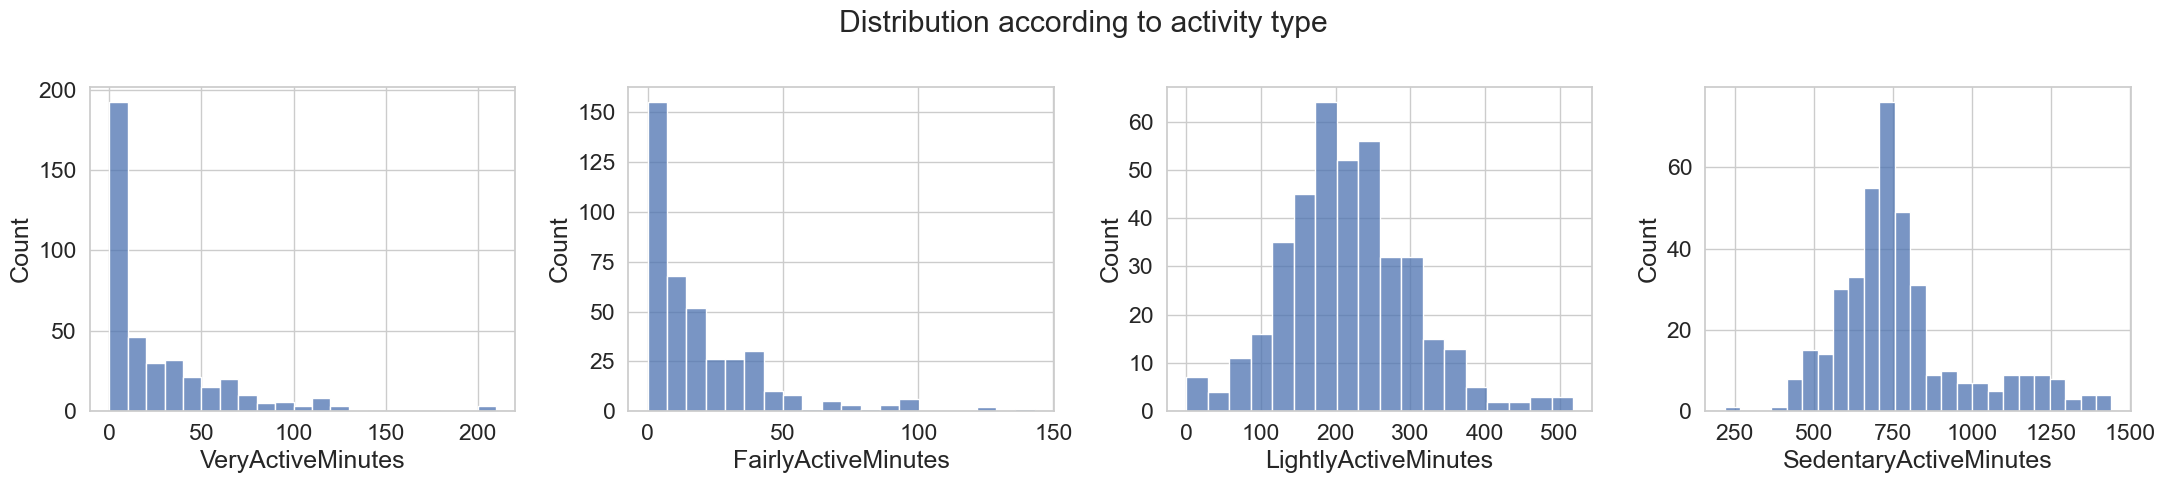

In [116]:
df = df.rename(columns={"SedentaryMinutes": "SedentaryActiveMinutes"})
df_scaled = df_scaled.rename(columns={"SedentaryMinutes": "SedentaryActiveMinutes"})

fig, axes = plt.subplots(1, 4, figsize=(22, 5))
res=fig.suptitle('Distribution according to activity type')

res=sns.histplot(data=df, x='VeryActiveMinutes', ax=axes[0])
res=sns.histplot(data=df, x='FairlyActiveMinutes', ax=axes[1])
res=sns.histplot(data=df, x='LightlyActiveMinutes', ax=axes[2])
res=sns.histplot(data=df, x='SedentaryActiveMinutes', ax=axes[3])

fig.tight_layout()
plt.show()

Evidently, many participants spent minimal time being either Very Active or Fairly Active.<br>
On the contrary, the distributions of LightlyActiveMinutes and SedentaryActiveMinutes have a symmetrical pattern, resembling normal distributions.


**Distribution of sleeping minutes**<br>
Let's also explore the distribution of the total minutes spent sleeping. And the total minutes spent in bed.<br>
There are two types of sleep related minutes in the dataset, TotalMinutesAsleep and TotalMinutesInBed.

Let's also create a third variable which is the minutes spent awake in bed. This is obtained by subtracting the minutes spent asleep from the minutes spent in bed. Let us call this variable TotalMinutesAwakeInBed.<br>
After this we have three sleep related variables:

- TotalMinutesAsleep
- TotalMinutesInBed
- TotalMinutesAwakeInBed

Let's plot the distributions of these variables:


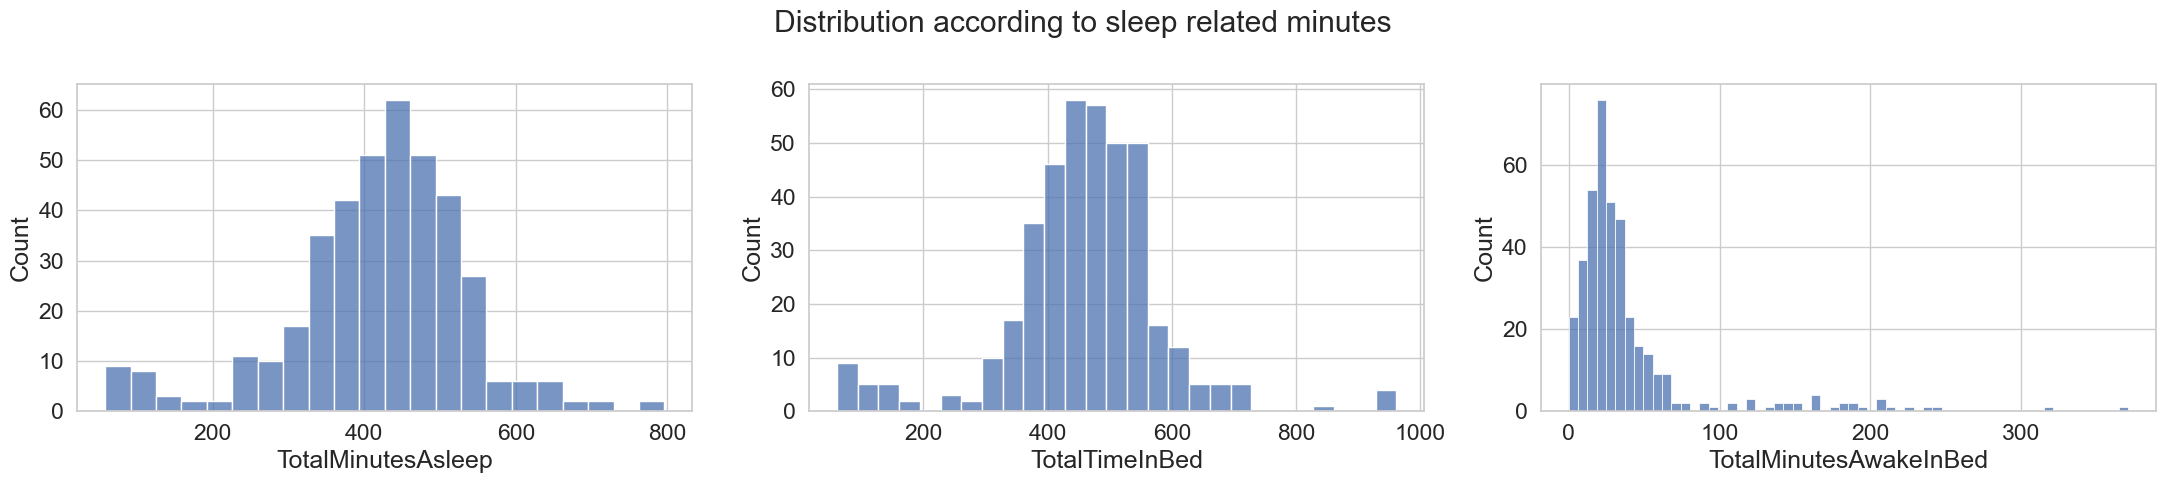

In [117]:
# Create the new variable
df['TotalMinutesAwakeInBed'] = df['TotalTimeInBed'] - df['TotalMinutesAsleep']

fig, axes = plt.subplots(1, 3, figsize=(22, 5))
res=fig.suptitle('Distribution according to sleep related minutes')

res=sns.histplot(data=df, x='TotalMinutesAsleep', ax=axes[0])
res=sns.histplot(data=df, x='TotalTimeInBed', ax=axes[1])
res=sns.histplot(data=df, x='TotalMinutesAwakeInBed', ax=axes[2])

fig.tight_layout()
plt.show()

TotalMinutesAsleep and TotalTimeInBed seem normally distributed, while TotalMinutesAwakeInBed has a very long tail. TotalMinutesAwakeInBed (and thus TotalTimeInBed) has two very large values which might be outliers. Let's take a closer look at the rows that contain these values:

In [118]:
# Remember that we have both original and scaled version of the dataframe

df[df['TotalMinutesAwakeInBed'] > 300]
df_scaled[df['TotalMinutesAwakeInBed'] > 300]

# Make sure we're about to drop same rows from the original and scaled frame
for value, value_scaled in zip(df[df['TotalMinutesAwakeInBed'] > 300].Id.values, df_scaled[df['TotalMinutesAwakeInBed'] > 300].Id.values):
  assert value == value_scaled


,Id,Weekday,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryActiveMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed,SumActiveMinutes,TotalMinutesAwakeInBed
Date,,,,,,,,,,,,,,,,,,,
2016-04-14,1844505072,Thursday,7937,5.25,5.25,0.0,0.0,0.0,5.23,0.0,0,0,373,843,2130,644,961,373,317
2016-04-30,1844505072,Saturday,4014,2.67,2.67,0.0,0.0,0.0,2.65,0.0,0,0,184,218,1763,590,961,184,371


,Id,Weekday,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryActiveMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed,SumActiveMinutes
Date,,,,,,,,,,,,,,,,,,
2016-04-14,1844505072,Thursday,-0.164499,-0.276089,-0.274802,-0.219288,-0.768793,-0.746106,0.831630,-0.099675,-0.711438,-0.804312,1.811908,0.324638,-0.386320,1.902160,3.934362,1.231934
2016-04-30,1844505072,Saturday,-1.108955,-1.128886,-1.128929,-0.219288,-0.768793,-0.746106,-0.659809,-0.099675,-0.711438,-0.804312,-0.370602,-2.660161,-0.892088,1.446799,3.934362,-0.827777


Since there are only two rows with values greater than 300, we can remove them from the dataframe:


In [119]:

print("The dataframe contained", df.shape[0], "rows.")
# Drop from both original and scaled
df_scaled = df_scaled[df['TotalMinutesAwakeInBed'] < 300]
df = df[df['TotalMinutesAwakeInBed'] < 300]
print("The dataframe now contains", df.shape[0], "rows.")

print(df.shape[0], type(df.shape[0]))
print(df_scaled.shape[0], type(df_scaled.shape[0]))
assert df.shape[0] == df_scaled.shape[0]

The dataframe contained 397 rows.
The dataframe now contains 395 rows.
395 <class 'int'>
395 <class 'int'>


**Compare sleep length with recommendation by National Institutes of Health (NIH)**<br><br>
According to NIH Consensus Conference Panel adults should sleep at least 7 hours every night to promote optimal health. Let us next compare this recommendation with the group level data of total minutes asleep and visualize this comparison.

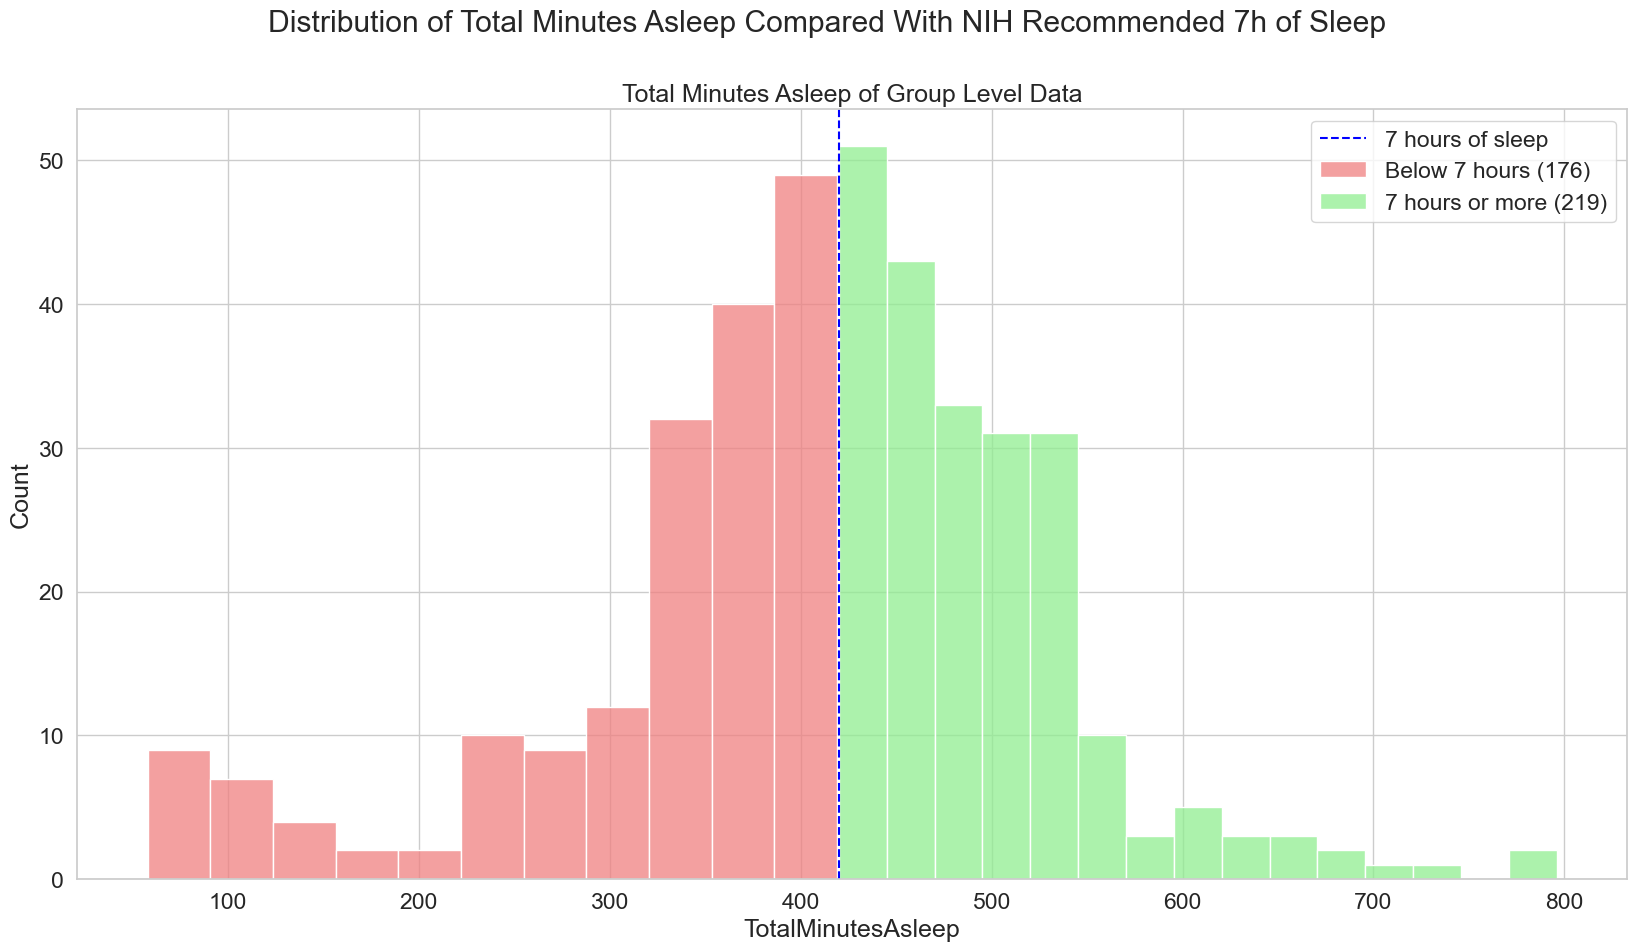

In [120]:
threshold_minutes = 7 * 60  # 7 hours in minutes

# Let's split the total minutes asleep data by the threshold
below_threshold = df[df['TotalMinutesAsleep'] < threshold_minutes]
above_threshold = df[df['TotalMinutesAsleep'] >= threshold_minutes]

# Plot histograms with different colors for the two groups
fig, ax = plt.subplots(figsize=(20, 10))
res=fig.suptitle('Distribution of Total Minutes Asleep Compared With NIH Recommended 7h of Sleep')

# Plot for 'TotalMinutesAsleep'
res=sns.histplot(data=below_threshold, x='TotalMinutesAsleep', color='lightcoral', label=f'Below 7 hours ({len(below_threshold)})', ax=ax, kde=False)
res=sns.histplot(data=above_threshold, x='TotalMinutesAsleep', color='lightgreen', label=f'7 hours or more ({len(above_threshold)})', ax=ax, kde=False)
res=ax.axvline(threshold_minutes, color='blue', linestyle='--', label='7 hours of sleep')
res=ax.legend()
res=ax.set_title('Total Minutes Asleep of Group Level Data')

Majority of the nights people slept enough!

As we did already at the indiviudal level, let's next plot **Boxplots** depicting the distributions of activity and total sleep by weekday.<br>
Along the boxplots let's also **superimpose individual observations** in one figure.

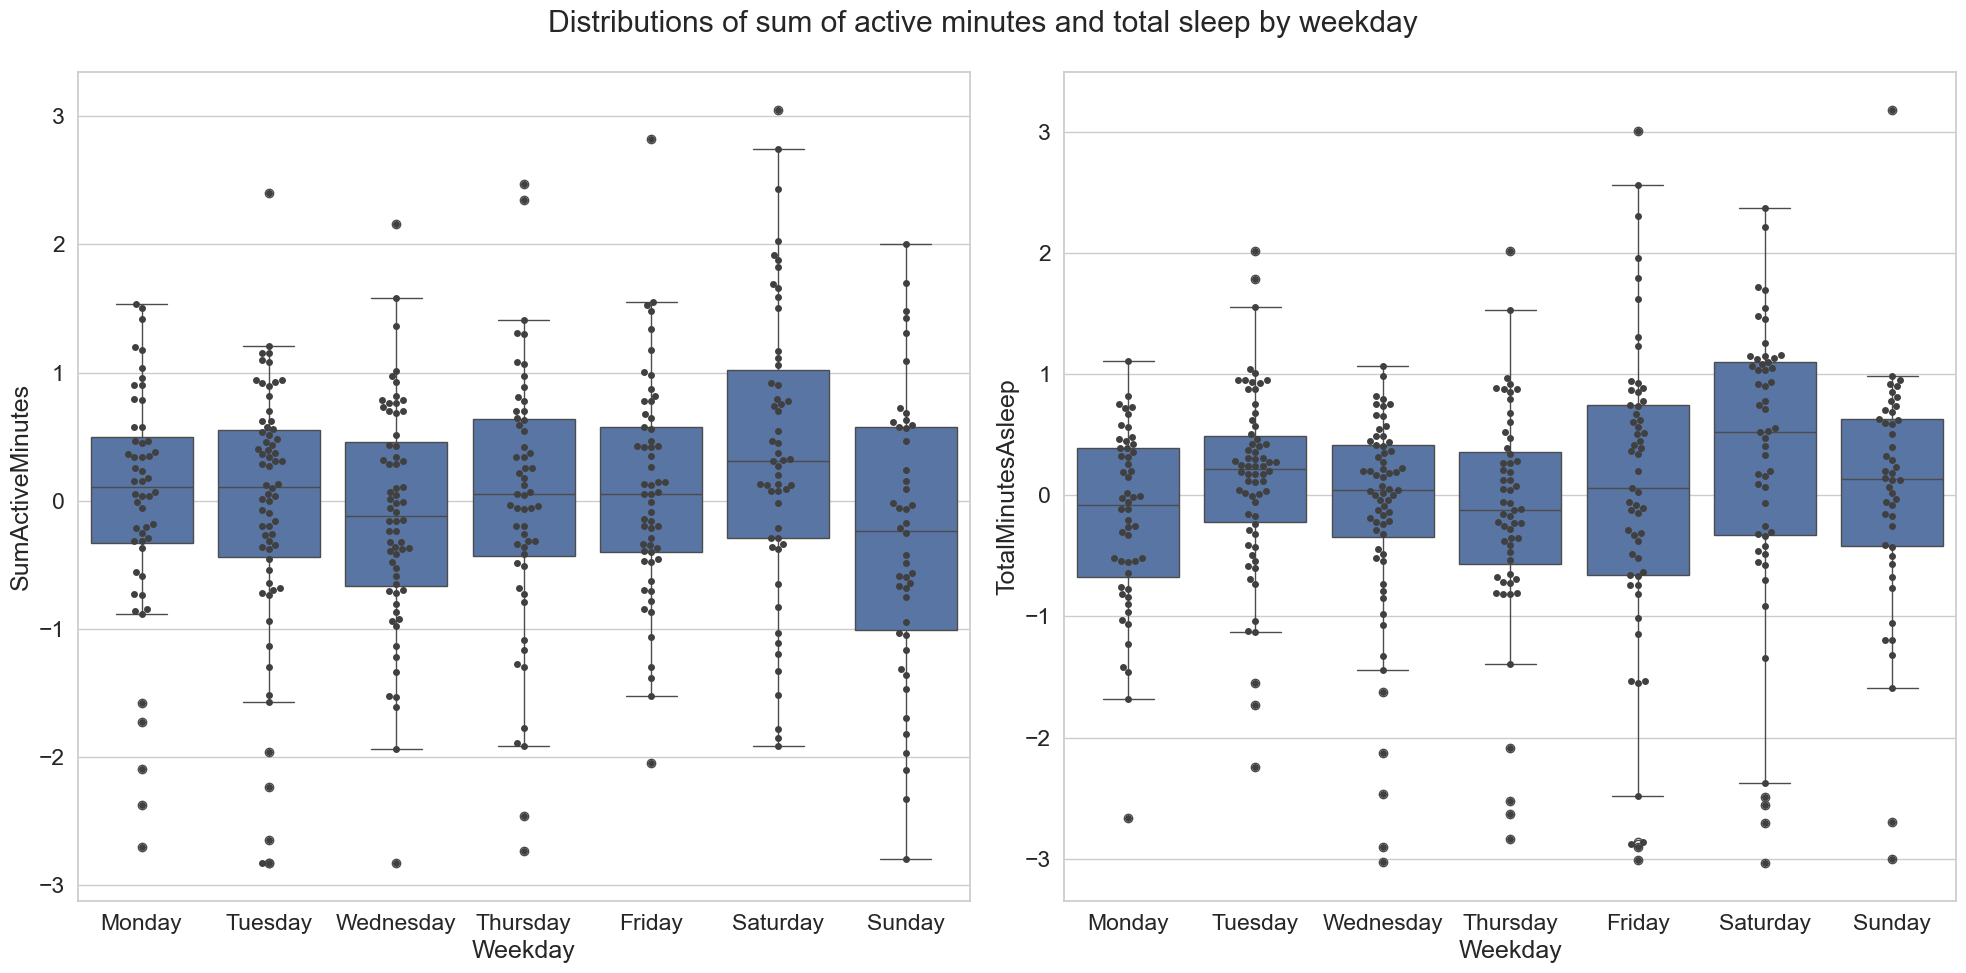

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
res=fig.suptitle('Distributions of sum of active minutes and total sleep by weekday')

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

res=sns.boxplot(y="SumActiveMinutes",
            x="Weekday",
            order=order,
            data=df_scaled,
            ax=axes[0])

res=sns.swarmplot(y="SumActiveMinutes", 
              x="Weekday",
              order=order,
              data=df_scaled, 
              color=".25",
              ax=axes[0])

res=sns.boxplot(y="TotalMinutesAsleep",
            x="Weekday",
            order=order,
            data=df_scaled,
            ax=axes[1])

res=sns.swarmplot(y="TotalMinutesAsleep", 
              x="Weekday",
              order=order,
              data=df_scaled, 
              color=".25",
              ax=axes[1])

fig.tight_layout()
plt.show()

The plots above aren't anymore as interpretable as they were at the individual level, but it definently seems that the activity tends to be lowest on Sundays.

Let's then plot the correlation matrix for the features at the group level.

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix')

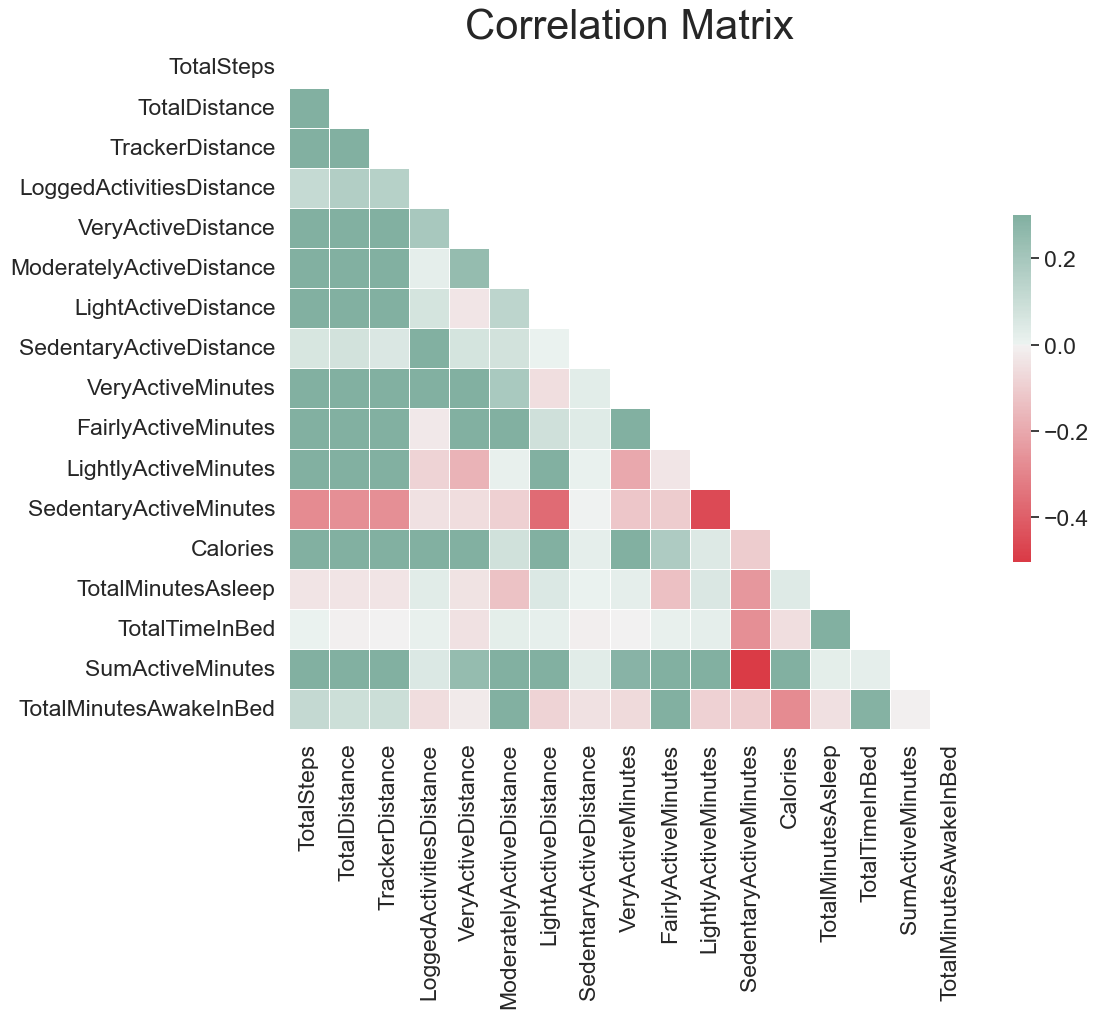

In [122]:
# Drop id and weekday information from the correlation matrix
corr = df.drop(columns=['Id', 'Weekday']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Don't show the gridlines
ax.grid(False)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(730, 520, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix", fontsize=30)

Again, even at the group level it seems that there isn't that strong of a correlation between the sum of active minutes and total minutes asleep, though there is small positive correlation. Still, many correlations that we saw at the individual level seem to hold at the group level as well. For example, correlation between sum of active minutes and calories burned.

### Clustering the data

Let's next try clustering the data. The goal here is to identify patterns in lifestyle habits and group individuals with similar behaviors. We will use [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans) Clustering to group individuals based on:
total daily active minutes (`SumActiveMinutes`), sedentary minutes (`SedentaryActiveMinutes`), total minutes asleep (`TotalMinutesAsleep`), and daily calories burned (`Calories`).<br>
Note that we're not taking account the fact that the same subject appears on several rows. This is because we are not trying to group individuals, but instead looking if the clustering could recognize patterns for different daily habits affecting health<br>
We hope to discover whether these daily habits could fall into categories like "active," "sedentary," "sleep-deprived," etc.<br>
We can then later try to cluster individuals.<br><br>
Note that we use the **scaled** features here!

In [123]:
# Extract features as numpy ndarray
X = df_scaled[["SumActiveMinutes", "TotalMinutesAsleep", "Calories", "SedentaryActiveMinutes"]].values

X

array([[ 1.15564842, -0.29031984, -0.58614627, -0.22456511],
       [-0.4136551 , -0.05420663, -0.8741721 ,  2.11551691],
       [ 0.13124196, -0.66135488, -0.91689363, -0.23411647],
       ...,
       [-1.97206068, -0.02890879, -0.61784289,  0.28165671],
       [-1.73230597,  0.82278528, -0.54480284,  0.67326228],
       [-1.13291921,  0.17347396, -0.15617469, -0.17203266]])

#### Choosing the proper k for our clustering

We will try out different values of *k*, *2 <= k <= 8*. At every different iteration of k, we will plot their corresponding [silhouette scores](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.silhouette_score.html) and [Calinski-Harabasz indices](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.calinski_harabasz_score.html) to see which number of clusters yields the best score. Code is adapted from the course programming assignment 4, namely from the notebook as2 [[1]](#references).

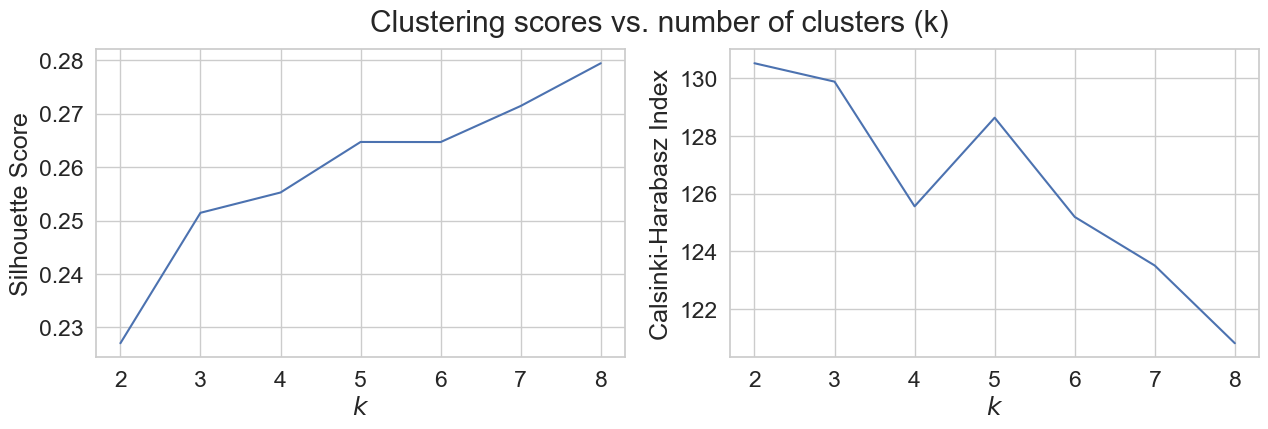

In [124]:
ks = range(2, 9)
silhouettes = []
calinskis = []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=SEED, max_iter=int(1e5), n_init=100)
    kmeans = kmeans.fit(X)
    clusters = kmeans.labels_
    silhouettes.append(silhouette_score(X, clusters))
    calinskis.append(calinski_harabasz_score(X, clusters))
    
res=axes[0].plot(ks, silhouettes)
res=axes[1].plot(ks, calinskis)
    
res=axes[0].set_xlabel("$k$"), axes[1].set_xlabel("$k$")
res=axes[0].set_ylabel("Silhouette Score")
res=axes[1].set_ylabel("Calsinki-Harabasz Index")
res=fig.suptitle("Clustering scores vs. number of clusters (k)")

plt.show()

From the plot above, we can identify "elbow" points. Elbow point is a point where the improvement in the score significantly slows down. This often corresponds to the optimal value of k. The first such point seems to be at **k = 3**. This also agrees with our preproposed idea that there would be three classes such as like "active" "sedentary" and "sleep-deprived". Even though looking at the metrics above it could be that the metrics suggest higher values of k as well, but we will have to keep in mind that too many clusters can dilute interpretability. **Thus we will choose k=3 to our following clustering analysis.**

In [125]:
k = 3
# Let us add the information about the cluster label to the dataframe
k_means_final = KMeans(n_clusters=k, random_state=SEED, max_iter=int(1e5), n_init=100)
k_means_final = k_means_final.fit(X)
df['Cluster'] = k_means_final.labels_
df_scaled['Cluster'] = k_means_final.labels_

df

,Id,Weekday,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryActiveMinutes,Calories,TotalMinutesAsleep,TotalTimeInBed,SumActiveMinutes,TotalMinutesAwakeInBed,Cluster
Date,,,,,,,,,,,,,,,,,,,,
2016-04-12,1503960366,Tuesday,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985,384,407,366,23,0
2016-04-14,1503960366,Thursday,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776,412,442,222,30,2
2016-04-15,1503960366,Friday,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745,340,367,272,27,0
2016-04-16,1503960366,Saturday,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863,700,712,267,12,0
2016-04-18,1503960366,Monday,13019,8.59,8.59,0.0,3.25,0.64,4.71,0.0,42,16,233,1149,1921,304,320,291,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-29,8792009665,Friday,8360,5.35,5.35,0.0,0.14,0.28,4.93,0.0,6,14,380,634,3101,343,360,400,17,1
2016-04-30,8792009665,Saturday,7174,4.59,4.59,0.0,0.33,0.36,3.91,0.0,10,20,301,749,2896,503,527,331,24,1
2016-05-01,8792009665,Sunday,1619,1.04,1.04,0.0,0.00,0.00,1.04,0.0,0,0,79,834,1962,415,423,79,8,0


##### Visualizing the clusters

Let's next visualize how the calories, activity minutes, sedentary minutes and sleep are distributed among our three clusters.

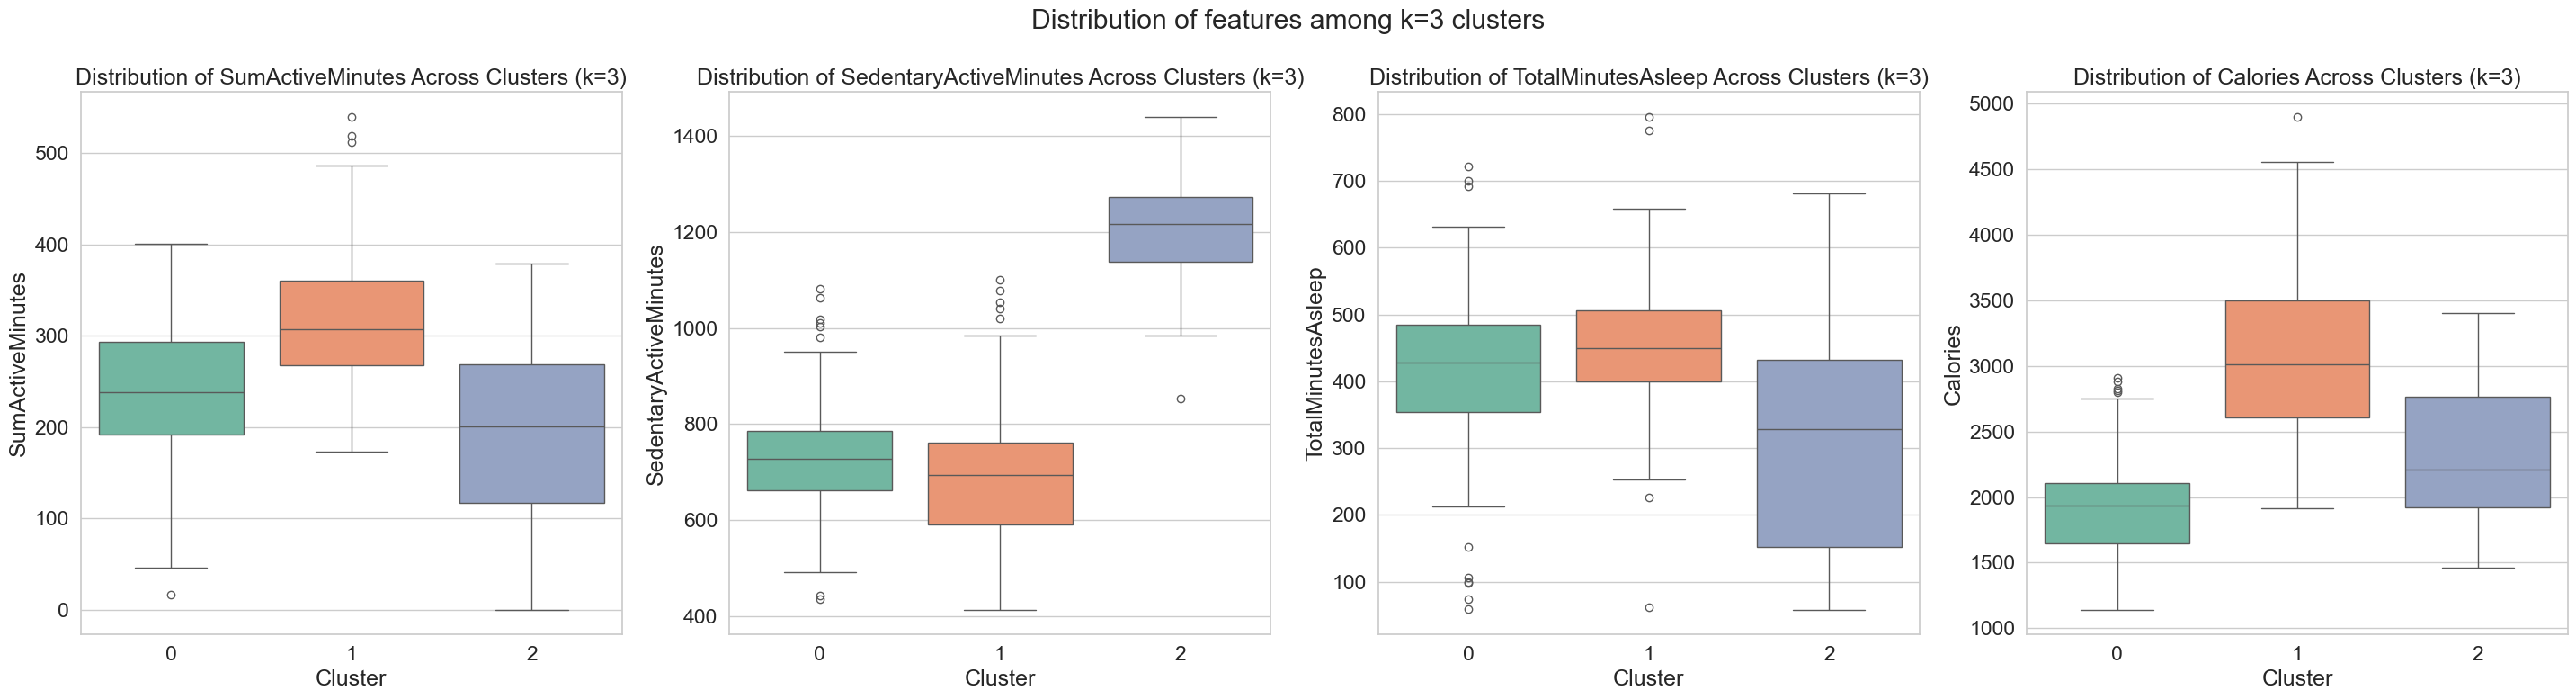

In [126]:
# Boxplot for feature distributions across clusters
fig, axes = plt.subplots(1, 4, figsize=(29, 8))
res=fig.suptitle(f'Distribution of features among k={k} clusters')
for i, column in enumerate(['SumActiveMinutes', 'SedentaryActiveMinutes', 'TotalMinutesAsleep', 'Calories']):
    res=sns.boxplot(x='Cluster', y=column, data=df, palette='Set2', ax=axes[i])
    res=axes[i].set_title(f'Distribution of {column} Across Clusters (k={k})') 
    res=axes[i].set_xlabel('Cluster')
    res=axes[i].set_ylabel(column)

plt.tight_layout()  # Adjust spacing
plt.show()

It seems that the daily habits belonging to cluster 0 consist of fairly active days, spent fairly less time sedentary, but not burning that much calories comparing to other clusters. The cluster 1 seems to capture the most healthy habits of having a lot of daily activity, less sedentary time, great sleeping minutes and a lot of calories burnt. The cluster 2 seems to capture the unhealthiest habits.

Let's replot the same figure but this time naming the clusters with respect to the aforementioned observations:

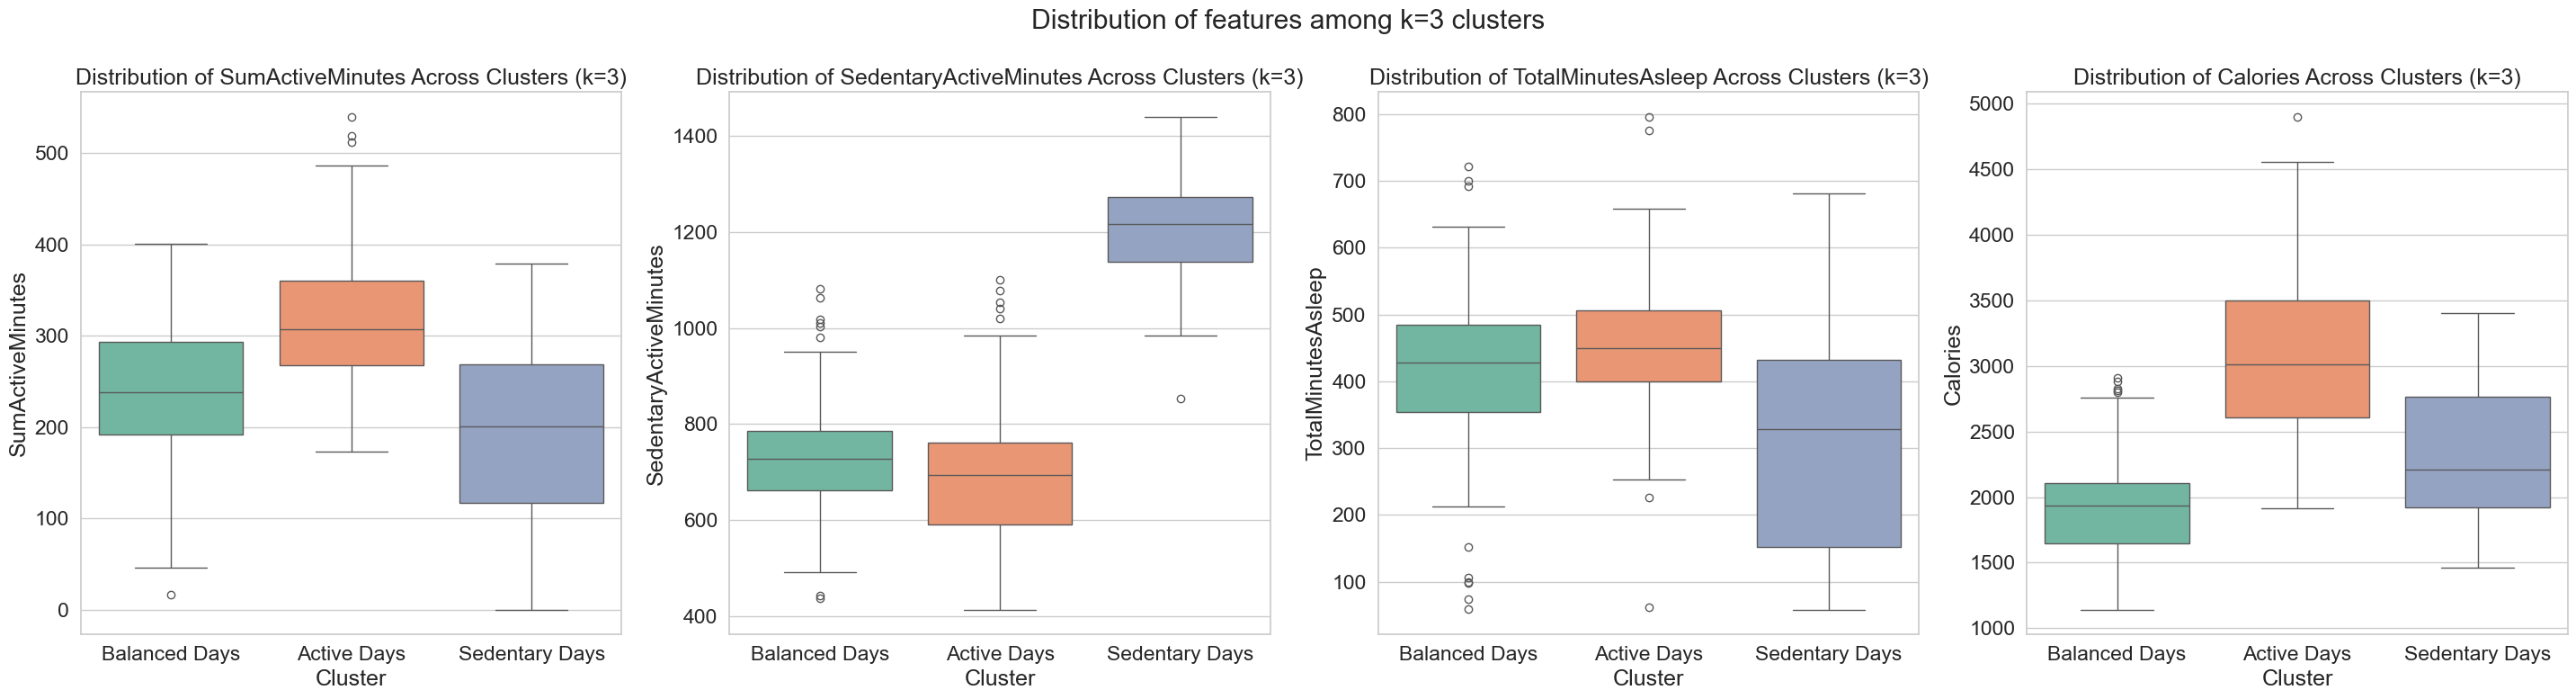

In [128]:
# Boxplot for feature distributions across clusters
cluster_names = {0: "Balanced Days", 1: "Active Days", 2: "Sedentary Days"}
fig, axes = plt.subplots(1, 4, figsize=(29, 8))
res=fig.suptitle(f'Distribution of features among k={k} clusters')
for i, column in enumerate(['SumActiveMinutes', 'SedentaryActiveMinutes', 'TotalMinutesAsleep', 'Calories']):
    res=sns.boxplot(x='Cluster', y=column, data=df, palette='Set2', ax=axes[i])
    res=res.set_xticklabels(["Balanced Days", "Active Days", "Sedentary Days"])
    res=axes[i].set_title(f'Distribution of {column} Across Clusters (k={k})') 
    res=axes[i].set_xlabel('Cluster')
    res=axes[i].set_ylabel(column)

plt.tight_layout()  # Adjust spacing
plt.show()

**visualizing the distribution of clusters among subjects**<br>
Since we are having multiple entries from the same subject ID in different clusters, it can be interesting to visualize how the different subjects fall into different clusters.


<Figure size 1200x800 with 0 Axes>

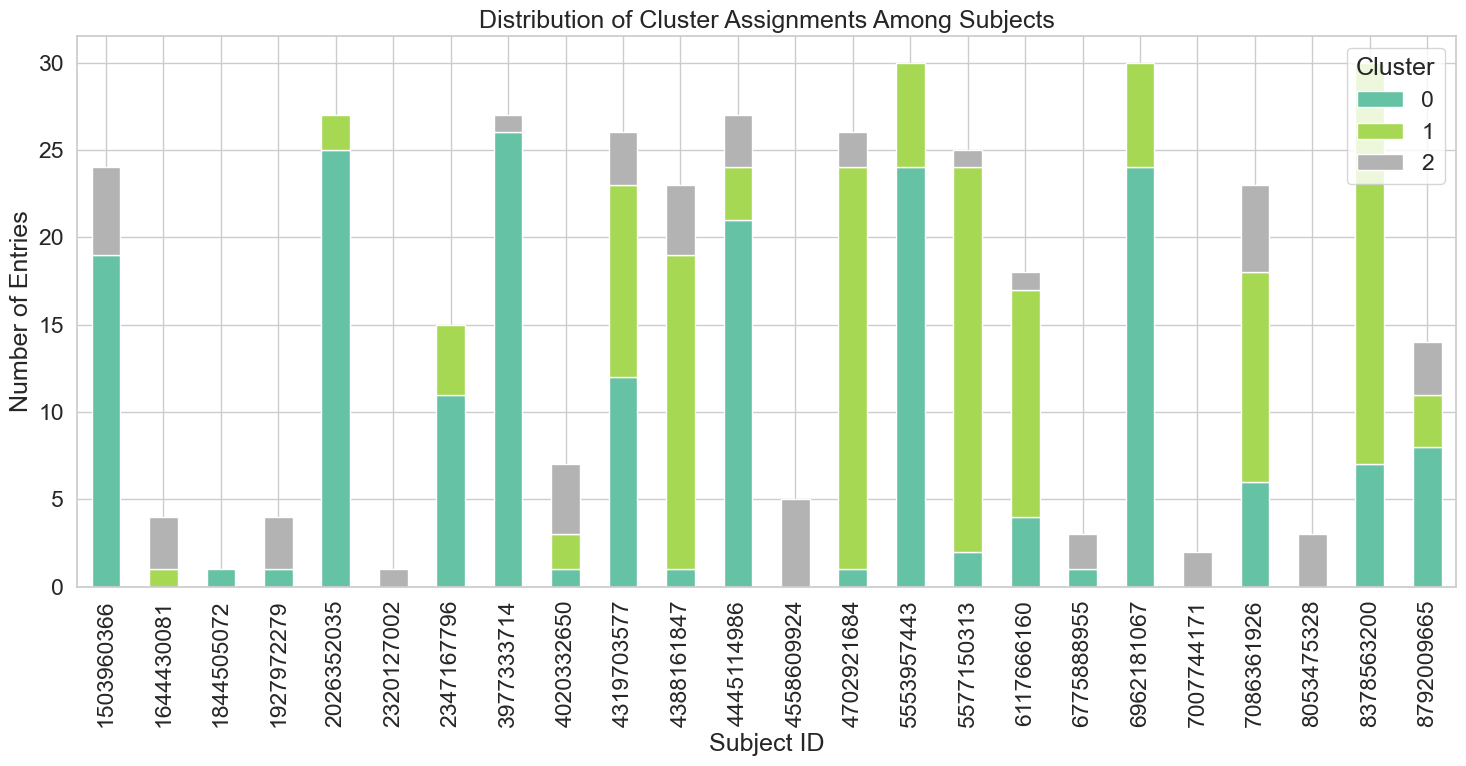

In [79]:
# Count the number of entries per subject in each cluster
subject_cluster_counts = df.groupby(['Id', 'Cluster']).size().unstack(fill_value=0)

# Plot the distribution of clusters among subjects
res=plt.figure(figsize=(12, 8))
res=subject_cluster_counts.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='Set2')
res=plt.title('Distribution of Cluster Assignments Among Subjects')
res=plt.xlabel('Subject ID')
res=plt.ylabel('Number of Entries')
res=plt.legend(title='Cluster')
res=plt.tight_layout()
plt.show()

Looking at the plot above, the subjects have a bar consisting mostly of one color, some consisting only of one color. This means that a subject seem to embody one lifestyle most of the time of the measurement.

**Clustering individuals**

It might be interesting to cluster subjects rather than individual entries. To cluster subjects we need to aggregate the data by subject, e.g. by using averages or sums of relevant features<br>
We will now proceed to aggreagate data by subject and then we will re-run clustering on the aggregated data. This ensures that each subject is assigned to a single cluster.

We do the aggregating using [groupBy](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) and [agg](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html):

In [80]:
# Group data by id and compute the mean for each feature
aggregated_data = df.groupby('Id').agg({
    'SumActiveMinutes': 'mean',
    'SedentaryActiveMinutes': 'mean',
    'TotalMinutesAsleep': 'mean',
    'Calories': 'mean'
}).reset_index()

print(f"Shape of the aggregated data: {aggregated_data.shape}")
aggregated_data.head()


Shape of the aggregated data: (24, 5)


,Id,SumActiveMinutes,SedentaryActiveMinutes,TotalMinutesAsleep,Calories
0,1503960366,288.50000,849.250000,361.666667,1886.083333
1,1644430081,219.25000,1099.250000,294.000000,2926.500000
2,1844505072,247.00000,1082.000000,722.000000,1856.000000
3,1927972279,41.00000,1192.250000,333.750000,2191.500000
4,2026352035,257.37037,683.407407,506.296296,1552.444444


We see that we have only 24 entries after the aggregation, that is, we have 24 individual subjects.<br><br>
Let's next continue to normalize the aggregated data and then re-do both choosing the k for the clustering and then the actual clustering:

In [81]:
# Do the scaling
aggregated_data_scaled = aggregated_data.copy()
sc = StandardScaler()
aggregated_data_scaled.iloc[:, 1:] = sc.fit_transform(aggregated_data_scaled.iloc[:, 1:])
aggregated_data_scaled.head()

,Id,SumActiveMinutes,SedentaryActiveMinutes,TotalMinutesAsleep,Calories
0,1503960366,0.692642,-0.251337,-0.102838,-0.869554
1,1644430081,-0.307924,0.995069,-0.583504,0.956075
2,1844505072,0.093025,0.909067,2.456768,-0.922342
3,1927972279,-2.883390,1.458732,-0.301143,-0.333637
4,2026352035,0.242862,-1.078165,0.924530,-1.454994


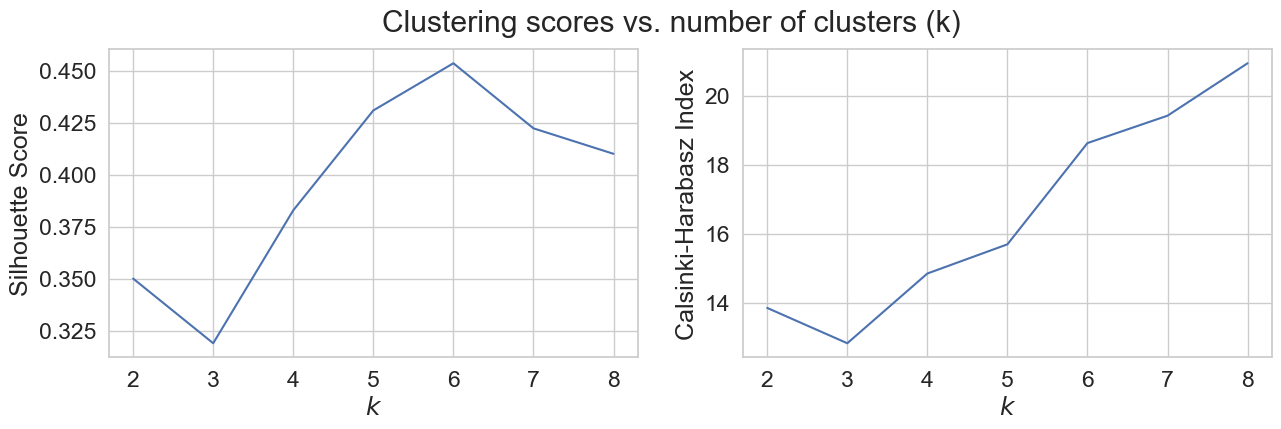

In [82]:
X_agg = aggregated_data_scaled[["SumActiveMinutes", "TotalMinutesAsleep", "Calories", "SedentaryActiveMinutes"]].values

ks = range(2, 9)
silhouettes = []
calinskis = []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=SEED, max_iter=int(1e5), n_init=100)
    kmeans = kmeans.fit(X_agg)
    clusters = kmeans.labels_
    silhouettes.append(silhouette_score(X_agg, clusters))
    calinskis.append(calinski_harabasz_score(X_agg, clusters))
    
res=axes[0].plot(ks, silhouettes)
res=axes[1].plot(ks, calinskis)
    
res=axes[0].set_xlabel("$k$"), axes[1].set_xlabel("$k$")
res=axes[0].set_ylabel("Silhouette Score")
res=axes[1].set_ylabel("Calsinki-Harabasz Index")
res=fig.suptitle("Clustering scores vs. number of clusters (k)")

plt.show()

Let's again use the first "elbow" point of the two graphs, which seems to now be at *k = 4*. Let us choose that and continue to the clustering and further visualizations:

In [83]:
k = 4
# Let us add the information about the cluster label to the dataframe
k_means_final = KMeans(n_clusters=k, random_state=SEED, max_iter=int(1e5), n_init=100)
k_means_final = k_means_final.fit(X_agg)
aggregated_data['Cluster'] = k_means_final.labels_
aggregated_data_scaled['Cluster'] = k_means_final.labels_

aggregated_data.head()

,Id,SumActiveMinutes,SedentaryActiveMinutes,TotalMinutesAsleep,Calories,Cluster
0,1503960366,288.50000,849.250000,361.666667,1886.083333,2
1,1644430081,219.25000,1099.250000,294.000000,2926.500000,0
2,1844505072,247.00000,1082.000000,722.000000,1856.000000,2
3,1927972279,41.00000,1192.250000,333.750000,2191.500000,0
4,2026352035,257.37037,683.407407,506.296296,1552.444444,2


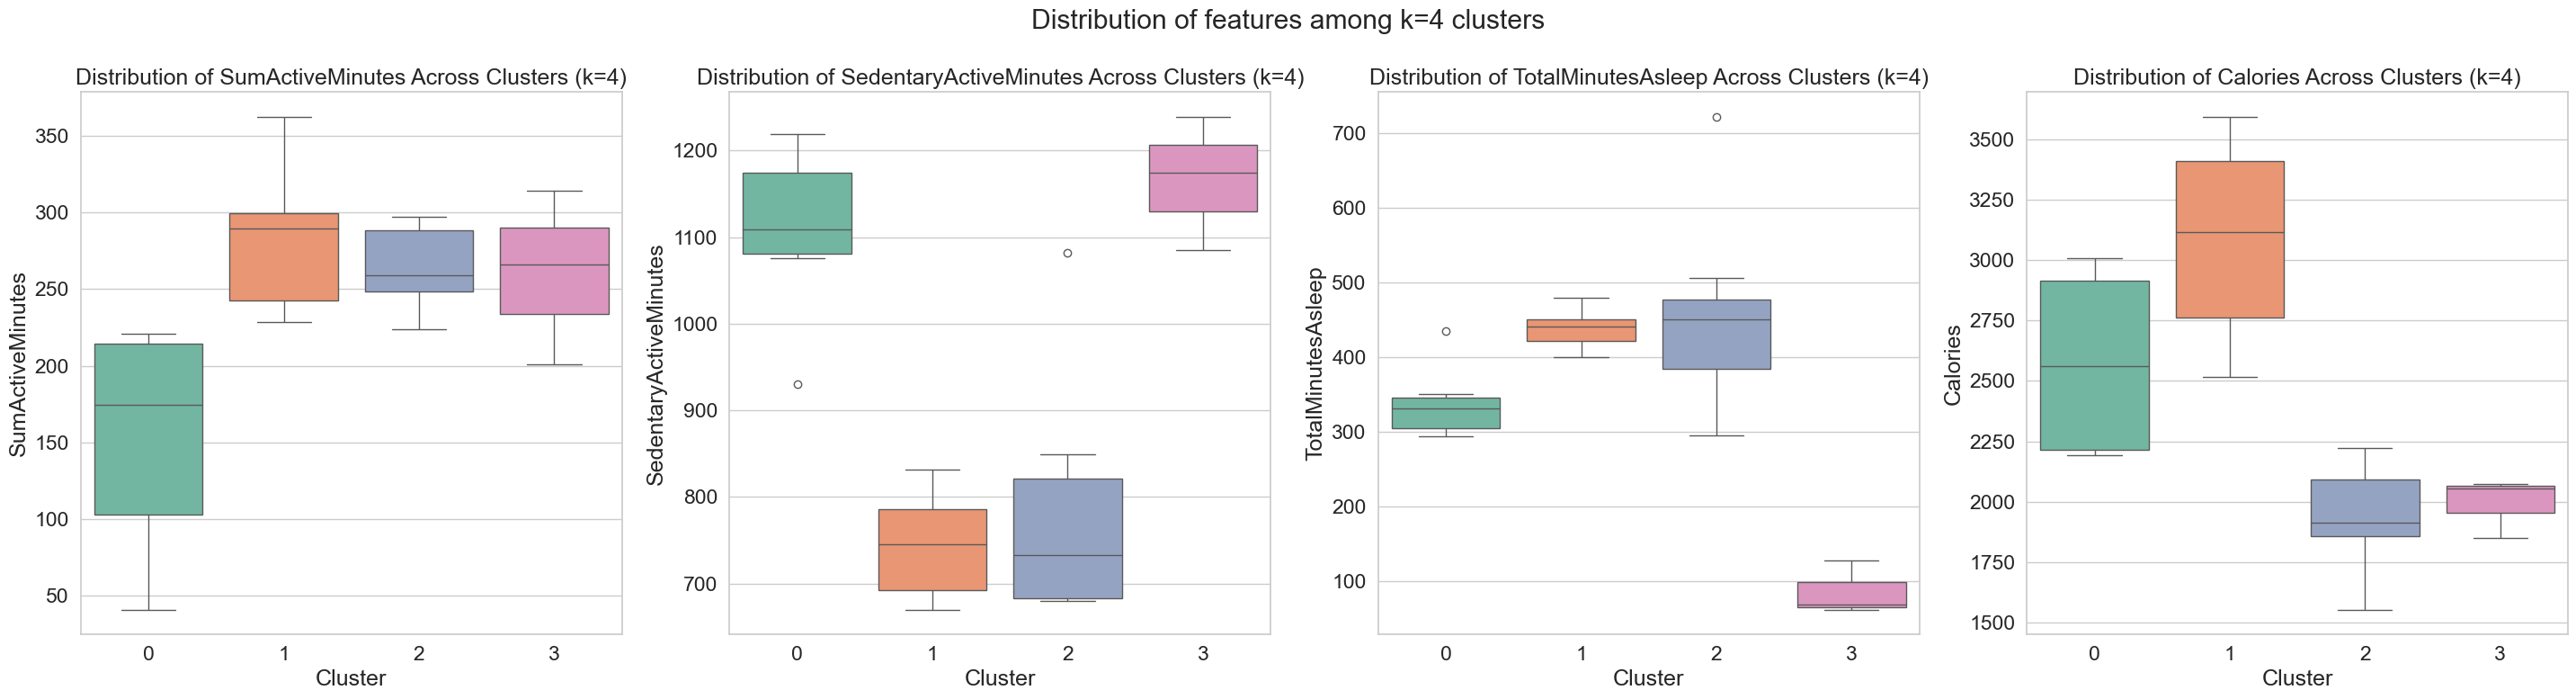

In [84]:
# Boxplot for feature distributions across clusters
fig, axes = plt.subplots(1, 4, figsize=(29, 8))
res=fig.suptitle(f'Distribution of features among k={k} clusters')
for i, column in enumerate(['SumActiveMinutes', 'SedentaryActiveMinutes', 'TotalMinutesAsleep', 'Calories']):
    res=sns.boxplot(x='Cluster', y=column, data=aggregated_data, palette='Set2', ax=axes[i])
    res=axes[i].set_title(f'Distribution of {column} Across Clusters (k={k})') 
    res=axes[i].set_xlabel('Cluster')
    res=axes[i].set_ylabel(column)

plt.tight_layout()  # Adjust spacing
plt.show()

Looking at the boxplots above, it seems that a rough division into two clusters could work as well, and possibly give us rough division of healthy living and unhealthy living individuals. Let's try out that as well:

In [85]:
k = 2
# Let us add the information about the cluster label to the dataframe
k_means_final = KMeans(n_clusters=k, random_state=SEED, max_iter=int(1e5), n_init=100)
k_means_final = k_means_final.fit(X_agg)
aggregated_data['Cluster_2'] = k_means_final.labels_
aggregated_data_scaled['Cluster_2'] = k_means_final.labels_

aggregated_data.head()

,Id,SumActiveMinutes,SedentaryActiveMinutes,TotalMinutesAsleep,Calories,Cluster,Cluster_2
0,1503960366,288.50000,849.250000,361.666667,1886.083333,2,0
1,1644430081,219.25000,1099.250000,294.000000,2926.500000,0,1
2,1844505072,247.00000,1082.000000,722.000000,1856.000000,2,0
3,1927972279,41.00000,1192.250000,333.750000,2191.500000,0,1
4,2026352035,257.37037,683.407407,506.296296,1552.444444,2,0


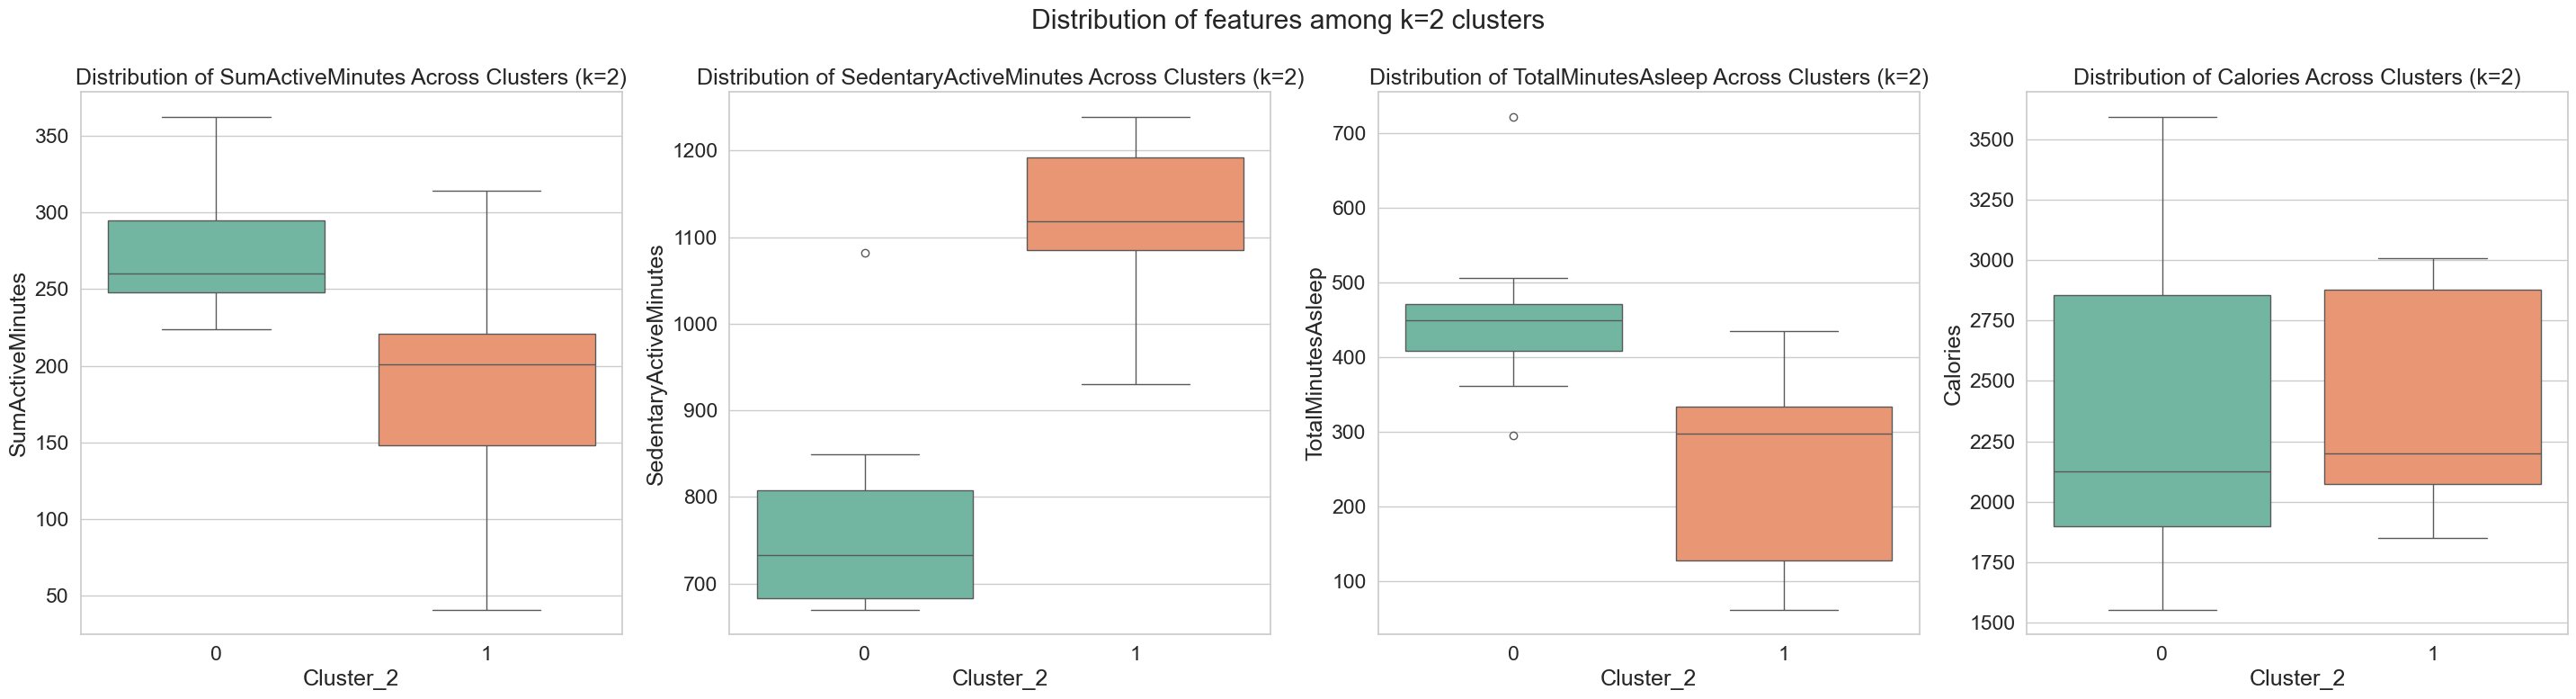

In [86]:
# Boxplot for feature distributions across clusters
fig, axes = plt.subplots(1, 4, figsize=(29, 8))
res=fig.suptitle(f'Distribution of features among k={k} clusters')
for i, column in enumerate(['SumActiveMinutes', 'SedentaryActiveMinutes', 'TotalMinutesAsleep', 'Calories']):
    res=sns.boxplot(x='Cluster_2', y=column, data=aggregated_data, palette='Set2', ax=axes[i])
    res=axes[i].set_title(f'Distribution of {column} Across Clusters (k={k})') 
    res=axes[i].set_xlabel('Cluster_2')
    res=axes[i].set_ylabel(column)

plt.tight_layout()  # Adjust spacing
plt.show()

Clustering the subjects into two clusters seems to well separate people into healthy and unhealthy people, roughly speaking. Indeed it seems that people being more active are the same people who also sleep longer!

Let us quickly further analyze how do individuals in the two clusters meet the standards of NIH provided 7h of sleep and 42 minutes of moderate-intensity physical activity a day (300mins a week). To achieve this we have to first re-aggregate our data, to obtain also the average of the sum of the veryActiveMinutes and FairlyActiveMinutes per individual. The sum of the veryActiveMinutes and FairlyActiveMinutes per individual will then represent the moderately active time spent by individuals. Let us than plot pie charts depicting how well the recommendations are met within clusters.

In [87]:
df['ModerateActiveMinutes'] = df[["VeryActiveMinutes", "FairlyActiveMinutes"]].sum(axis=1)

# Group data by id and compute the mean for each feature
activity_aggregated_data = df.groupby('Id').agg({
    'SumActiveMinutes': 'mean',
    'ModerateActiveMinutes': 'mean',
    'SedentaryActiveMinutes': 'mean',
    'TotalMinutesAsleep': 'mean',
    'Calories': 'mean'
}).reset_index()

activity_aggregated_data = activity_aggregated_data.merge(aggregated_data[["Id", "Cluster", "Cluster_2"]], on='Id')

activity_aggregated_data.head()

,Id,SumActiveMinutes,ModerateActiveMinutes,SedentaryActiveMinutes,TotalMinutesAsleep,Calories,Cluster,Cluster_2
0,1503960366,288.50000,61.750000,849.250000,361.666667,1886.083333,2,0
1,1644430081,219.25000,35.250000,1099.250000,294.000000,2926.500000,0,1
2,1844505072,247.00000,0.000000,1082.000000,722.000000,1856.000000,2,0
3,1927972279,41.00000,2.250000,1192.250000,333.750000,2191.500000,0,1
4,2026352035,257.37037,0.407407,683.407407,506.296296,1552.444444,2,0


C:\Users\Ilkka\AppData\Local\Temp\ipykernel_22836\2852217869.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_thresholds = activity_aggregated_data.groupby('Cluster_2').apply(


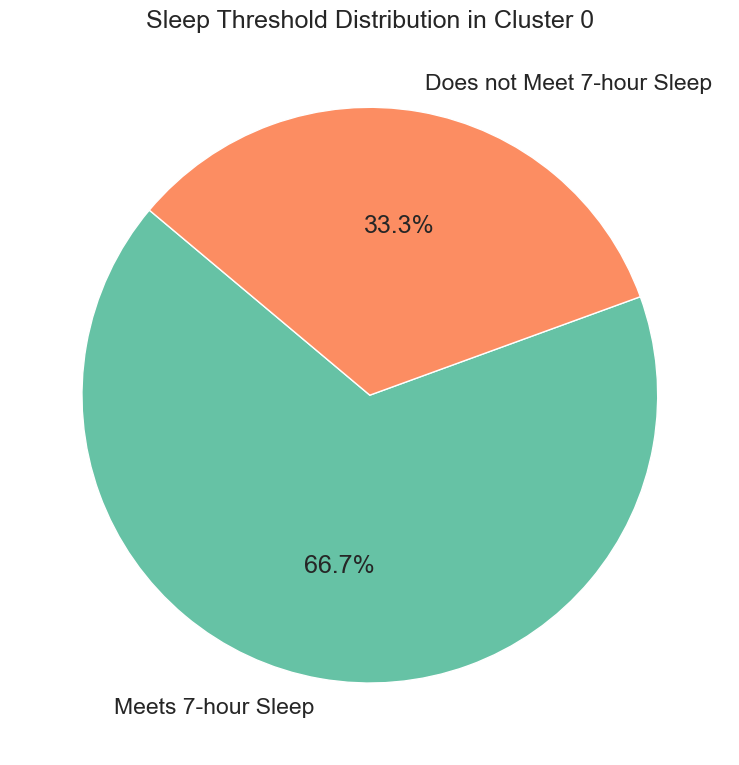

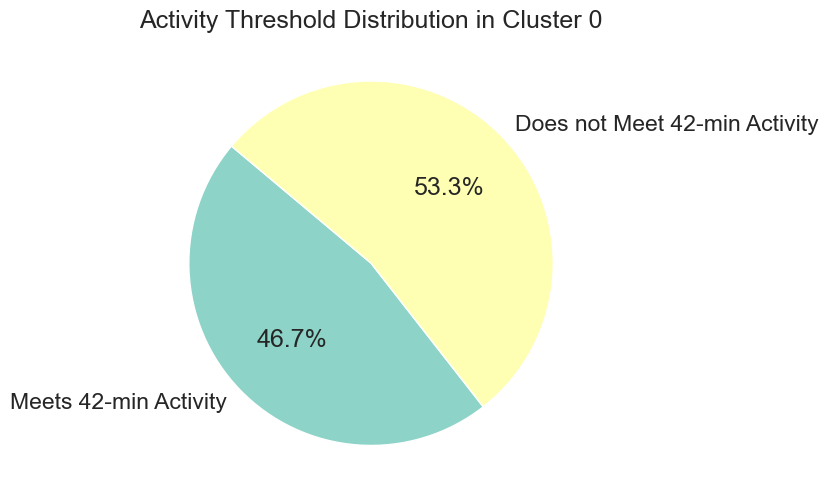

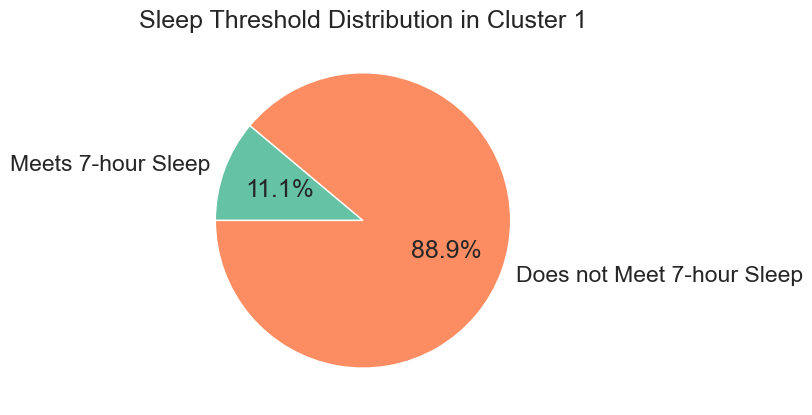

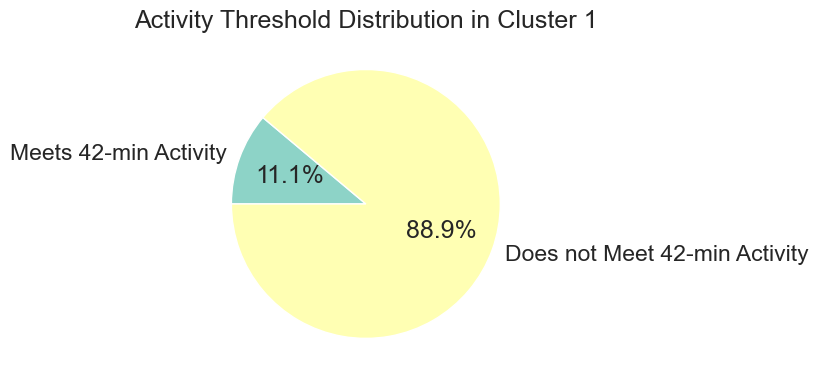

In [88]:
# Define thresholds
sleep_threshold = 420  # 7 hours sleep a night
activity_threshold = 42 # 300 minutes of activity a week

# Calculate the proportions of subjects meeting the thresholds in each cluster
cluster_thresholds = activity_aggregated_data.groupby('Cluster_2').apply(
    lambda group: pd.Series({
        'Meets_Sleep': (group['TotalMinutesAsleep'] >= sleep_threshold).mean(),
        'Not_Meets_Sleep': (group['TotalMinutesAsleep'] < sleep_threshold).mean(),
        'Meets_Activity': (group['ModerateActiveMinutes'] >= activity_threshold).mean(),
        'Not_Meets_Activity': (group['ModerateActiveMinutes'] < activity_threshold).mean()
    })
)

# Create pie charts for each cluster
for cluster in cluster_thresholds.index:
    # plotting the sleep distribution
    res=plt.figure(figsize=(8, 8))
    res=plt.pie(
        [cluster_thresholds.loc[cluster, 'Meets_Sleep'], cluster_thresholds.loc[cluster, 'Not_Meets_Sleep']],
        labels=['Meets 7-hour Sleep', 'Does not Meet 7-hour Sleep'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('Set2', 2)
    )
    res=plt.title(f'Sleep Threshold Distribution in Cluster {cluster}')
    res=plt.tight_layout()
    res=plt.show()

    # plottin the activity distribution
    res=plt.figure(figsize=(8, 8))
    res=plt.pie(
        [cluster_thresholds.loc[cluster, 'Meets_Activity'], cluster_thresholds.loc[cluster, 'Not_Meets_Activity']],
        labels=['Meets 42-min Activity', 'Does not Meet 42-min Activity'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('Set3', 2)
    )
    res=plt.title(f'Activity Threshold Distribution in Cluster {cluster}')
    res=plt.tight_layout()
    res=plt.show()

As we can see most of the individuals in the first cluster meet the sleep recommendations, and a bit less than half meet the moderate activity recommendation. In contrast individuals in the second cluster rarely meet any of the recommendations.

### Regression model for predicting the `TotalMinutesAsleep`

Since we've now noticed several times that the activity of an individual might gives insights about the individual's sleep quality, it is interesting to try to predict the total minutes asleep spent by an indivudal based on the activity data from the day before the night asleep.<br><br>
In this part two machine learning regression models [Random Forest Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) and [Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) are used to predict TotalMinutesAsleep based on ModerateActiveMinutes, SedentaryActiveMinutes, and Calories. A k fold cross validation is performed for the two models from which Root Mean Squared Errors are computed and then statistical justification whether other model is better than the other.

First, we'll prepare the data:

Note that we use the **original scaled data here**, that is, the data that's not aggregated to group level, since we are not interested to perform the predictions to the aggregated data.

In [89]:
# The scaled df is missing the moderate active minutes ( as scaled! ), so we'll quickly create that here
sc = StandardScaler()
df_scaled["ModerateActiveMinutes"] = sc.fit_transform(df[["ModerateActiveMinutes"]])

X = df_scaled[['ModerateActiveMinutes', 'SedentaryActiveMinutes', 'Calories']]
ids = df_scaled['Id']
y = df_scaled['TotalMinutesAsleep']

<br><br>
Let us start by building a cross-validation procedure to be used. Note that here we'll use [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) to make sure that same subject isn't accidentally put into both training and testing phases.

In [90]:
def cross_validation_procedure(X, y, subject_ids, model, n_splits=5, random_state=SEED):
    cv = GroupKFold(n_splits=n_splits)
    scores = []
    for train_idx, test_idx in cv.split(X, y, groups=subject_ids):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_te, y_te = X.iloc[test_idx], y.iloc[test_idx]

        # Fit the model
        model.fit(X_tr, y_tr)

        # Make predictions on the validation set
        y_pred = model.predict(X_te)

        # Compute the RMSE score for the validation set
        rmse = mean_squared_error(y_te, y_pred, squared=False)
        # Store the score of this fold
        scores.append(rmse)
    
    return scores

Next, we'll do the k fold for both of the models and then we will use wilcoxon signed rank test to assess whether one of the models performs better with statistically significant difference.

In [91]:
# Initialize the two models
rf = RandomForestRegressor(random_state=SEED)
gbr = GradientBoostingRegressor(random_state=SEED)

# Run the k fold procedure and store the RMSE scores
rf_rmse_scores = cross_validation_procedure(X, y, ids, rf)
gbr_rmse_scores = cross_validation_procedure(X, y, ids, gbr)

# Statistical comparison (Wilcoxon for RMSE)
stat, p_value = wilcoxon(rf_rmse_scores, gbr_rmse_scores)

# Print results
print(f"Random Forest RMSE: Mean={np.mean(rf_rmse_scores):.4f}, Std={np.std(rf_rmse_scores):.4f}")
print(f"Gradient Boosting RMSE: Mean={np.mean(gbr_rmse_scores):.4f}, Std={np.std(gbr_rmse_scores):.4f}")
print(f"Wilcoxon signed-rank test: W-statistic={stat:.4f}, p-value={p_value:.4f}")

# Determine better model
if p_value < 0.05:
    better_model = "Gradient Boosting" if np.mean(gbr_rmse_scores) < np.mean(rf_rmse_scores) else "Random Forest"
    print(f"Statistically significant difference: {better_model} performs better.")
else:
    print("No statistically significant difference between the models.")

Random Forest RMSE: Mean=1.0567, Std=0.0834
Gradient Boosting RMSE: Mean=1.0733, Std=0.0829
Wilcoxon signed-rank test: W-statistic=4.0000, p-value=0.4375
No statistically significant difference between the models.


The Random Forest model has a slightly lower mean RMSE compared to Gradient Boosting, indicating that it performed slightly better in terms of prediction error.<br>
The standard deviation (Std) of RMSE is comparable between the two models, indicating similar variability in performance across folds.

While Random Forest slightly outperforms Gradient Boosting in terms of mean RMSE, the difference is not statistically significant. Therefore, both models can be considered equivalent in terms of performance for this specific task. Let's choose the Random Forest Regressor since it has a slightly better RMSE, is easier to interpret (e.g., feature importance visualization), and it requires fewer hyperparameters to tune compared to Gradient Boosting.

#### Visualize Predictions and Performance of Random Forest Regressor

We choose to further analyze the Random Forest due to its slightly better performance and simpler interpretability.

In [92]:
# Split into training and test data (for demonstration purposes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²: {r2:.2f}")

RandomForestRegressor(random_state=99)

Model Performance:
  RMSE: 0.97
  R²: 0.13


**Feature Importance**

Let's next visualize which features contribute the most to the model's predictions.

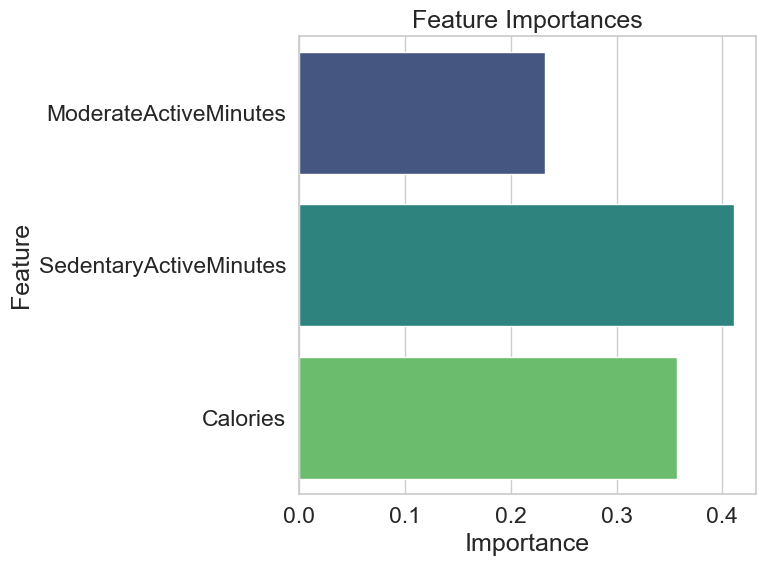

In [93]:
importances = rf.feature_importances_
feature_names = X.columns
res=plt.figure(figsize=(8, 6))
res=sns.barplot(x=importances, y=feature_names, palette='viridis')
res=plt.title('Feature Importances')
res=plt.xlabel('Importance')
res=plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**Predicted vs. Actual Values**


Next interesting thing to do is to plot a scatter plot of predicted vs. actual values to evaluate how well the model fits the data.

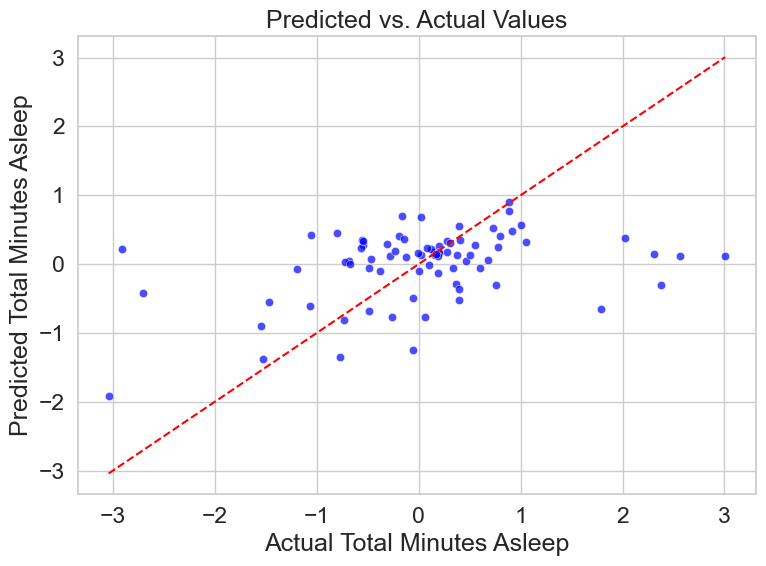

In [94]:
res=plt.figure(figsize=(8, 6))
res=sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.7)
res=plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line of perfect fit
res=plt.title('Predicted vs. Actual Values')
res=plt.xlabel('Actual Total Minutes Asleep')
res=plt.ylabel('Predicted Total Minutes Asleep')
plt.tight_layout()
plt.show()

**Residual Analysis**

Then let's plot residuals (errors) to try to analyze if the model has systematic bias.

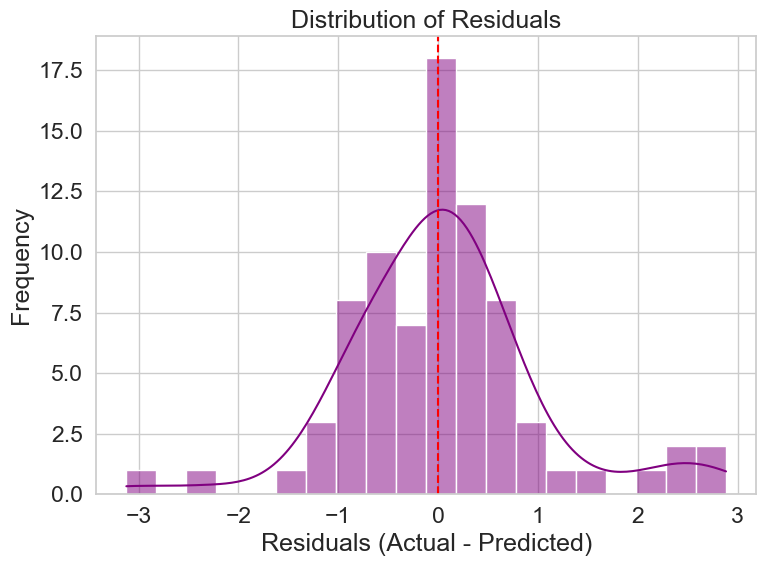

In [95]:
residuals = y_test - y_pred
res=plt.figure(figsize=(8, 6))
res=sns.histplot(residuals, kde=True, bins=20, color='purple')
res=plt.title('Distribution of Residuals')
res=plt.xlabel('Residuals (Actual - Predicted)')
res=plt.ylabel('Frequency')
res=plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

**Error Distribution**

Let's lastly plot the distribution of prediction errors to assess if errors are normally distributed.

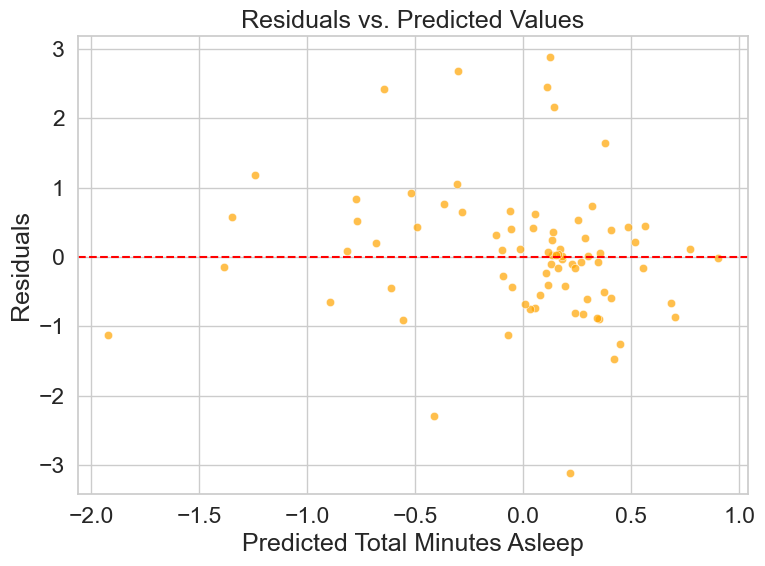

In [96]:
res=plt.figure(figsize=(8, 6))
res=sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, color='orange')
res=plt.axhline(0, color='red', linestyle='--')
res=plt.title('Residuals vs. Predicted Values')
res=plt.xlabel('Predicted Total Minutes Asleep')
res=plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

<a id='references'></a>
## References

[1] Course programming assignment notebooks



[2] https://seaborn.pydata.org/examples/many_pairwise_correlations.html